In [1]:
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import numpy as np
from   scipy.stats import norm
from scipy.stats import anderson
from math import log2
from math import sqrt
import json
import numpy as np
from scipy import stats
import math
import numpy as np
from scipy import stats

# Get annotations for each time series

In [2]:
with open('annotations.json') as f:
    annotations = json.load(f)

# Load each time series and standarize it

In [3]:
# DATASETS CAN BE FOUND HERE: https://github.com/alan-turing-institute/TCPDBench

DATASETS = [
#    "apple",
    "bank",
#    "bee_waggle_6",
    "bitcoin",
    "brent_spot",
    "businv",
    "centralia",
    "children_per_woman",
    "co2_canada",
    "construction",
    "debt_ireland",
    "gdp_argentina",
    "gdp_croatia",
    "gdp_iran",
    "gdp_japan",
    "global_co2",
    "homeruns",
#    "iceland_tourism",
    "jfk_passengers",
    "lga_passengers",
    "measles",
    "nile",
#    "occupancy",
    "ozone",
    "quality_control_1",
    "quality_control_2",
    "quality_control_3",
    "quality_control_4",
    "quality_control_5",
    "rail_lines",
    "ratner_stock",
    "robocalls",
#    "run_log",
    "scanline_126007",
    "scanline_42049",
    "seatbelts",
    "shanghai_license",
    "uk_coal_employ",
    "unemployment_nl",
    "usd_isk",
    "us_population",
    "well_log",
]
DATASETS = ['bank']
DATASET_NAMES = {k: k for k in DATASETS}

In [5]:
timeSeriesData = []

for dataset in DATASETS:
    filename = '..\\datasets\\'.format(dataset)
    with open(filename+'{}.json'.format(dataset)) as f:
        timeSeriesData.append(json.load(f))

In [6]:
stdTestingData = []

for i in range(len(timeSeriesData)):
    rawData = timeSeriesData[i]['series'][0]['raw']
    if None in rawData:
        indexOfNone = [u for u,v in enumerate(rawData) if v == None]
        for iN in indexOfNone:
            rawData[iN] = (rawData[iN-1] + rawData[iN+1]) / 2

    rawData = np.asarray(rawData)
    rawData = (rawData - np.mean(rawData)) / np.std(rawData)
    stdTestingData.append(rawData)
    print(len(stdTestingData[i]))
    if(len(stdTestingData[i])< 40):
        print(DATASETS[i])

stdTestingData = np.asarray(stdTestingData)

581


# Define Covering and F1-Score 

In [7]:
def true_positives(T, X, margin=5):
    """Compute true positives without double counting

    >>> true_positives({1, 10, 20, 23}, {3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 5, 8, 20})
    {1, 10, 20}
    >>> true_positives(set(), {1, 2, 3})
    set()
    >>> true_positives({1, 2, 3}, set())
    set()
    """
    # make a copy so we don't affect the caller
    X = set(list(X))
    TP = set()
    for tau in T:
        close = [(abs(tau - x), x) for x in X if abs(tau - x) <= margin]
        close.sort()
        if not close:
            continue
        dist, xstar = close[0]
        TP.add(tau)
        X.remove(xstar)
    return TP


def f_measure(annotations, predictions, margin=5, alpha=0.5, return_PR=False):
    """Compute the F-measure based on human annotations.

    annotations : dict from user_id to iterable of CP locations
    predictions : iterable of predicted CP locations
    alpha : value for the F-measure, alpha=0.5 gives the F1-measure
    return_PR : whether to return precision and recall too

    Remember that all CP locations are 0-based!

    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    """
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F


def overlap(A, B):
    """ Return the overlap (i.e. Jaccard index) of two sets

    >>> overlap({1, 2, 3}, set())
    0.0
    >>> overlap({1, 2, 3}, {2, 5})
    0.25
    >>> overlap(set(), {1, 2, 3})
    0.0
    >>> overlap({1, 2, 3}, {1, 2, 3})
    1.0
    """
    return len(A.intersection(B)) / len(A.union(B))


def partition_from_cps(locations, n_obs):
    """ Return a list of sets that give a partition of the set [0, T-1], as 
    defined by the change point locations.

    >>> partition_from_cps([], 5)
    [{0, 1, 2, 3, 4}]
    >>> partition_from_cps([3, 5], 8)
    [{0, 1, 2}, {3, 4}, {5, 6, 7}]
    >>> partition_from_cps([1,2,7], 8)
    [{0}, {1}, {2, 3, 4, 5, 6}, {7}]
    >>> partition_from_cps([0, 4], 6)
    [{0, 1, 2, 3}, {4, 5}]
    """
    T = n_obs
    partition = []
    current = set()

    all_cps = iter(sorted(set(locations)))
    cp = next(all_cps, None)
    for i in range(T):
        if i == cp:
            if current:
                partition.append(current)
            current = set()
            cp = next(all_cps, None)
        current.add(i)
    partition.append(current)
    return partition


def cover_single(Sprime, S):
    """Compute the covering of a segmentation S by a segmentation Sprime.

    This follows equation (8) in Arbaleaz, 2010.

    >>> cover_single([{1, 2, 3}, {4, 5}, {6}], [{1, 2, 3}, {4, 5, 6}])
    0.8333333333333334
    >>> cover_single([{1, 2, 3, 4}, {5, 6}], [{1, 2, 3, 4, 5, 6}])
    0.6666666666666666
    >>> cover_single([{1, 2}, {3, 4}, {5, 6}], [{1, 2, 3}, {4, 5, 6}])
    0.6666666666666666
    >>> cover_single([{1, 2, 3, 4, 5, 6}], [{1}, {2}, {3}, {4, 5, 6}])
    0.3333333333333333
    """
    T = sum(map(len, Sprime))
    assert T == sum(map(len, S))
    C = 0
    for R in S:
        C += len(R) * max(overlap(R, Rprime) for Rprime in Sprime)
    C /= T
    return C


def Covering(annotations, predictions, n_obs):
    """Compute the average segmentation covering against the human annotations.

    annotations : dict from user_id to iterable of CP locations
    predictions : iterable of predicted Cp locations
    n_obs : number of observations in the series

    >>> covering({1: [10, 20], 2: [10], 3: [0, 5]}, [10, 20], 45)
    0.7962962962962963
    >>> covering({1: [], 2: [10], 3: [40]}, [10], 45)
    0.7954144620811286
    >>> covering({1: [], 2: [10], 3: [40]}, [], 45)
    0.8189300411522634

    """
    Ak = {
        k + 1: partition_from_cps(annotations[uid], n_obs)
        for k, uid in enumerate(annotations)
    }
    pX = partition_from_cps(predictions, n_obs)

    Cs = [cover_single(pX, Ak[k]) for k in Ak]
    return sum(Cs) / len(Cs)

# SB-BOCPD

In [8]:
class BayesianOnlineChangePointDetection_Segment:
    def __init__(self, hazard, distribution):
        self.hazard = hazard
        self.distribution = distribution
        self.T = 0
        self.beliefs = np.zeros((1, 2),dtype=np.float64)
        self.beliefs[0, 0] = 1.0

    def reset_params(self):
        self.T = 0
        self.beliefs = np.zeros((1, 2))
        self.beliefs[0, 0] = 1.0

    def _expand_belief_matrix(self):
        rows = np.zeros((1, 2),dtype=np.float64)
        self.beliefs = np.concatenate((self.beliefs, rows), axis=0)

    def _shift_belief_matrix(self):
        self.beliefs[:, 0] = self.beliefs[:, 1]
        self.beliefs[:, 1] = 0.0

    def update(self, x, studentTQueue, historicalData):
        
        
        # Evaluate Predictive Probability (3 in Algortihm 1)
        if type(x) is not np.ndarray:
            self._expand_belief_matrix()

            self.distribution.update_params(x)
            # Update internal state
            #print(len(self.beliefs))

            self.T += 1
        else:
            self._expand_belief_matrix()
            


            pi_t = self.distribution.pdf(x, studentTQueue, historicalData)
            # Calculate H(r_{t-1})
            h = self.hazard(self.rt)

            self.beliefs[1 : self.T + 2, 1] = self.beliefs[: self.T + 1, 0] * pi_t * (1 - h)

            # Calculate Changepoint Probabilities (5 in Algorithm 1)
            self.beliefs[0, 1] = (self.beliefs[: self.T + 1, 0] * pi_t * h).sum()

            # Determine Run length Distribution (7 in Algorithm 1)
            self.beliefs[:, 1] = self.beliefs[:, 1] / self.beliefs[:, 1].sum()

            # Update sufficient statistics (8 in Algorithm 8)
            self.distribution.update_params(x[0])

            # Update internal state
            self._shift_belief_matrix()
            self.T += 1
            
            
        
        
    @property
    def rt(self):
       # return np.where(self.beliefs[:, 0] == self.beliefs[:, 0].max())[0]
    
        rtPick = np.where(self.beliefs[:, 0] > 0.5)[0]
        #print(rtPick)
        if(len(rtPick) == 0):
            return 0
        else:
            return rtPick[-1]
    @property
    def belief(self):
        return self.beliefs[:, 0]

class Hazard:
    def __call__(self, *args, **kwargs):
        raise NotImplementedError()


class ConstantHazard(Hazard):
    def __init__(self, _lambda):
        self._lambda = _lambda

    def __call__(self, r):
        """
        Args:
          r: The length of the current run (np.ndarray or scalar)

        Returns:
          p: Changepoint Probabilities(np.ndarray with shape = r.shape)
        """
        if isinstance(r, np.ndarray):
            shape = r.shape
        else:
            shape = 1

        return np.ones(shape) / self._lambda

class Distribution:
    def reset_params(self):
        raise NotImplementedError()

    def pdf(self, x):
        raise NotImplementedError()

    def update_params(self, x):
        raise NotImplementedError()


class StudentT(Distribution):
    """ Generalized Student t distribution 
    https://en.wikipedia.org/wiki/Student%27s_t-distribution#Generalized_Student's_t-distribution

    This setting corresponds to select
      1: Gaussian distribution as a likelihood
      2: normal-Gamma distribution as a prior for Gaussian
    """

    def __init__(self, mu=0, kappa=1, alpha=1, beta=1):
        self.mu0 = np.array([mu],dtype=np.float64)
        self.kappa0 = np.array([kappa],dtype=np.float64)
        self.alpha0 = np.array([alpha],dtype=np.float64)
        self.beta0 = np.array([beta],dtype=np.float64)
        # We need the following lines to prevent "outside defined warning"
        self.muT = self.mu0.copy()
        self.kappaT = self.kappa0.copy()
        self.alphaT = self.alpha0.copy()
        self.betaT = self.beta0.copy()

    def reset_params(self):
        self.muT = self.mu0.copy()
        self.kappaT = self.kappa0.copy()
        self.alphaT = self.alpha0.copy()
        self.betaT = self.beta0.copy()

    def pdf(self, x, studentTQueue, historicalData):
        """ Probability Density Function
        """

        
        return stats.t.pdf(
            np.average(x),
            loc=self.muT,
            df=2 * self.alphaT,
            scale=np.sqrt(self.betaT * (self.kappaT + 1) / (self.alphaT * self.kappaT)),
        )

    def update_params(self, x):
        """Update Sufficient Statistcs (Parameters)

        To understand why we use this, see e.g.
        Conjugate Bayesian analysis of the Gaussian distribution, Kevin P. Murphy∗
        https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
        3.5 Posterior predictive
        """
        self.betaT = np.concatenate(
            [
                self.beta0,
                (self.kappaT + (self.kappaT * (x - self.muT) ** 2) / (2 * (self.kappaT + 1))),
            ]
        )
        self.muT = np.concatenate([self.mu0, (self.kappaT * self.muT + x) / (self.kappaT + 1)])
        self.kappaT = np.concatenate([self.kappa0, self.kappaT + 1])
        self.alphaT = np.concatenate([self.alpha0, self.alphaT + 0.5])



# Test SB-BOCPD

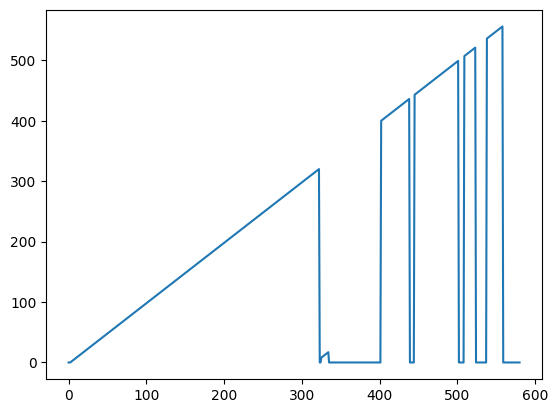

[321 333 437 500 522 557]


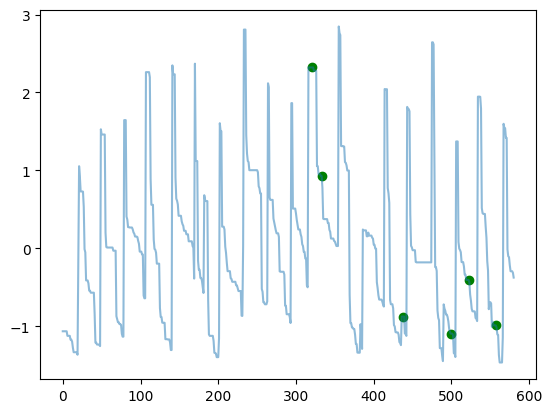

alpha0.01
beta0.01
kappa0.01
bank
F-Measure
0.25
Covering
0.5524956970740104


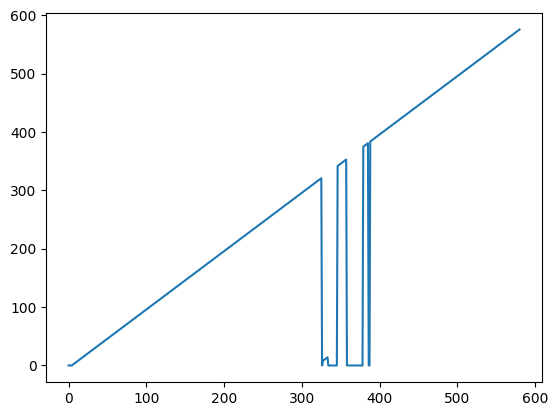

[323 331 355 383]


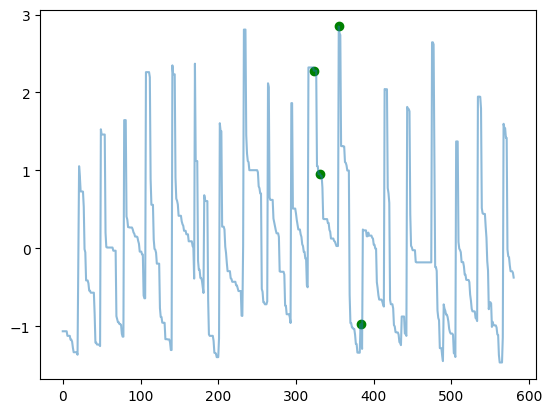

alpha0.01
beta0.01
kappa0.01
bank
F-Measure
0.33333333333333337
Covering
0.5559380378657487


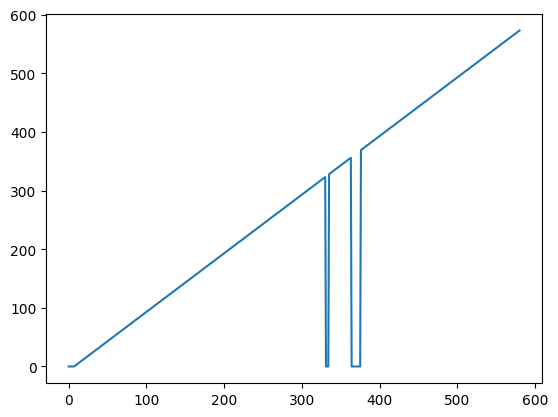

[326 359]


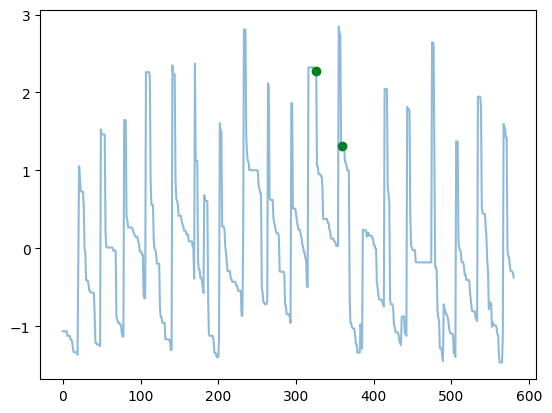

alpha0.01
beta0.01
kappa0.01
bank
F-Measure
0.5
Covering
0.5611015490533563


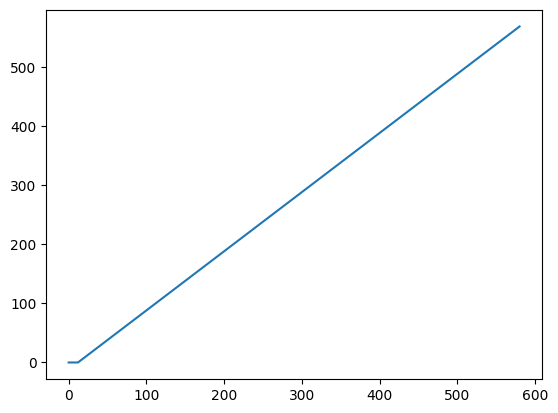

13
********************************


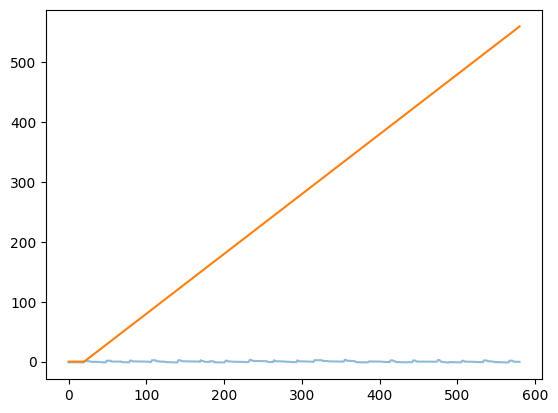

21
********************************


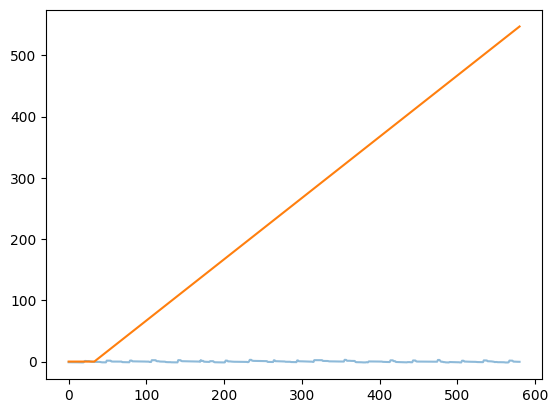

34
********************************


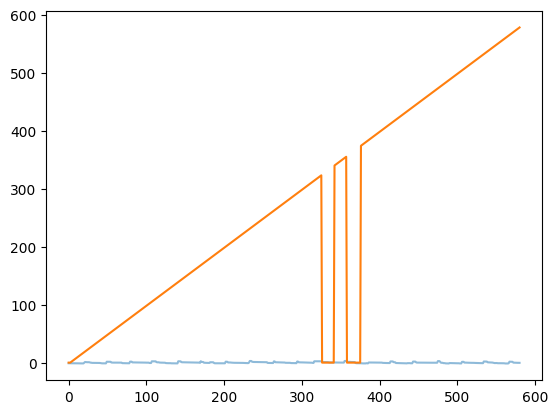

[324 356]


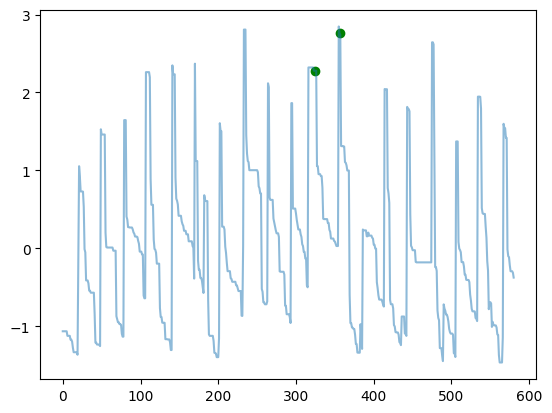

alpha0.01
beta0.01
kappa1
bank
F-Measure
0.5
Covering
0.5576592082616179


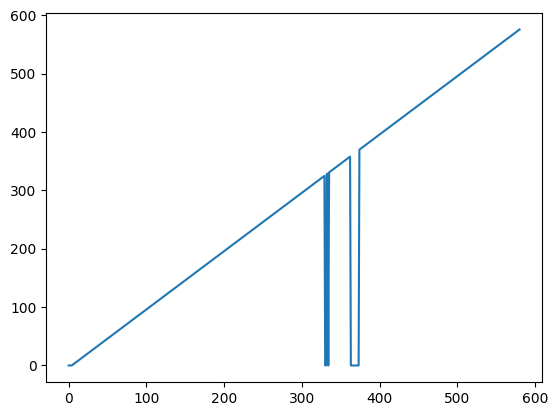

[327 331 360]


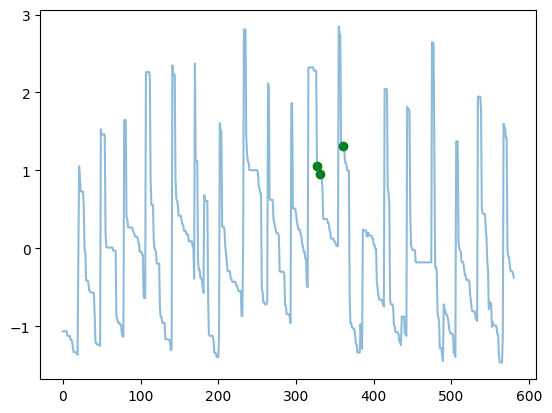

alpha0.01
beta0.01
kappa1
bank
F-Measure
0.4
Covering
0.5628227194492255


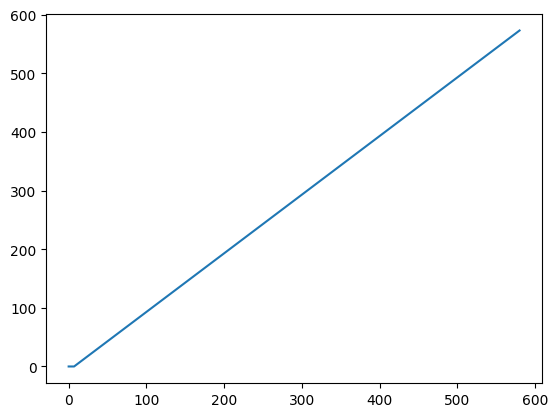

8
********************************


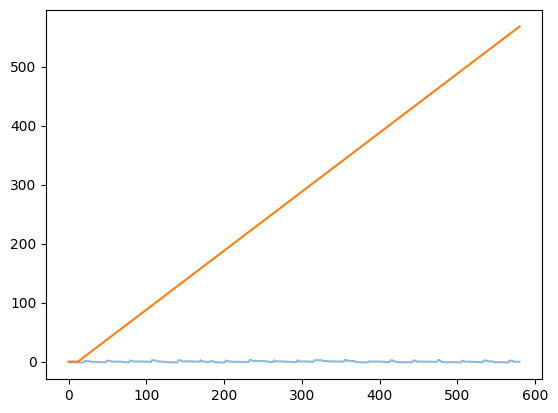

13
********************************


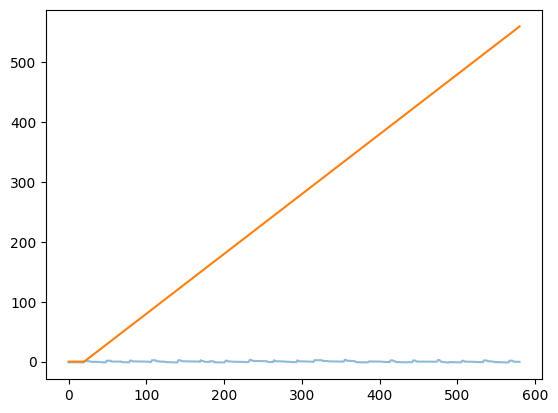

21
********************************


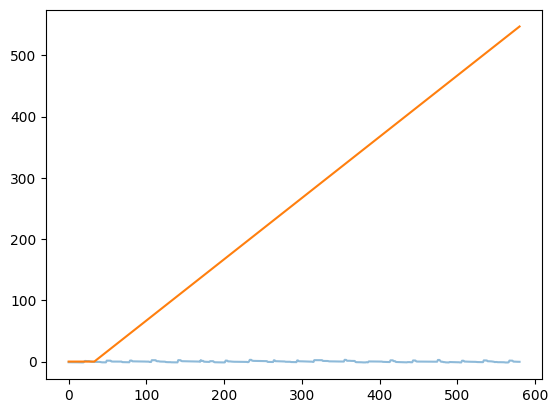

34
********************************


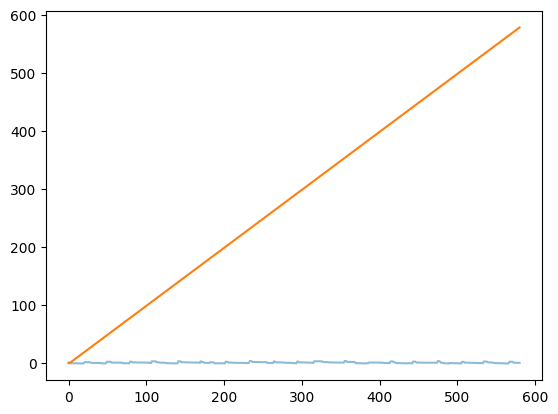

3
********************************


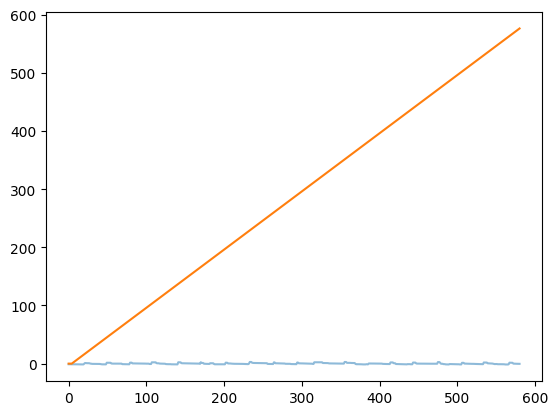

5
********************************


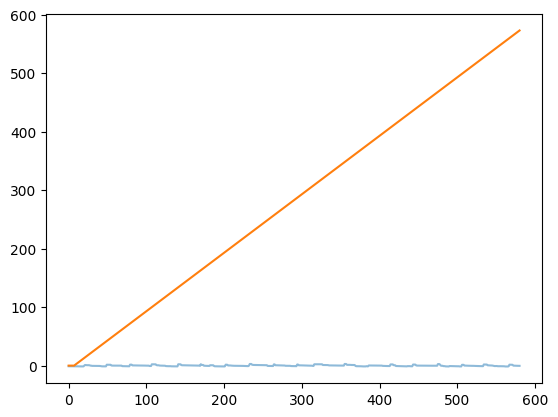

8
********************************


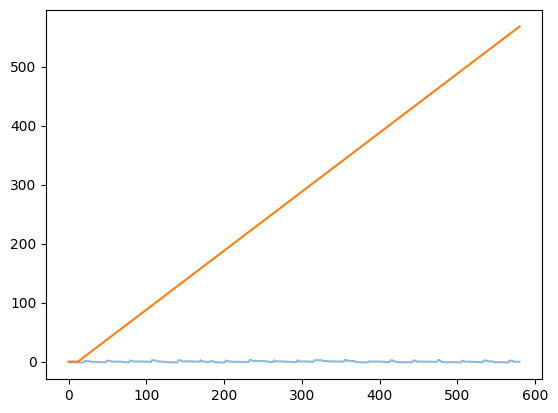

13
********************************


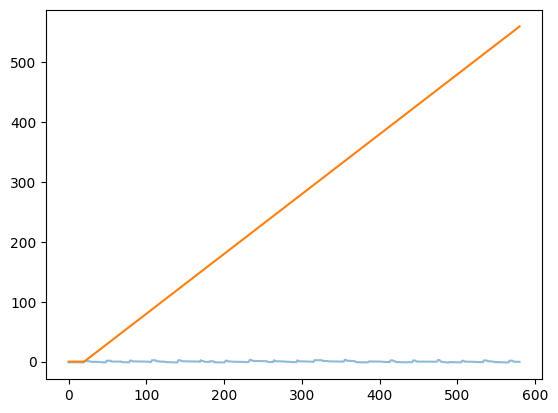

21
********************************


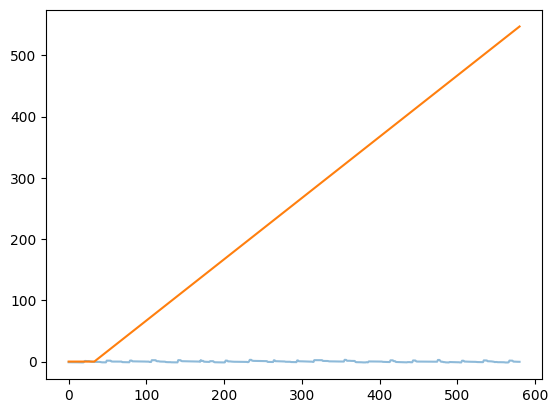

34
********************************


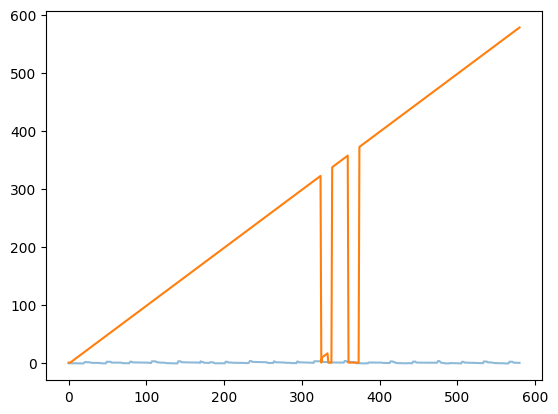

[323 332 358]


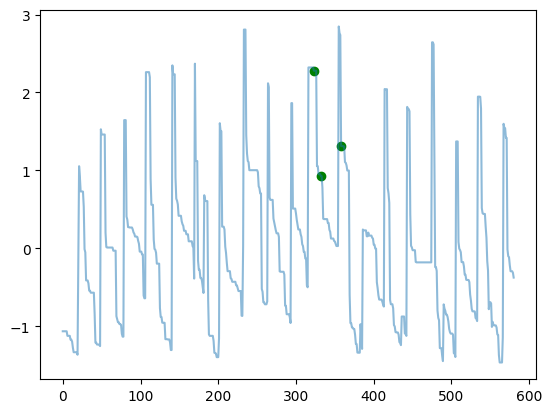

alpha0.01
beta1
kappa0.01
bank
F-Measure
0.4
Covering
0.5559380378657487


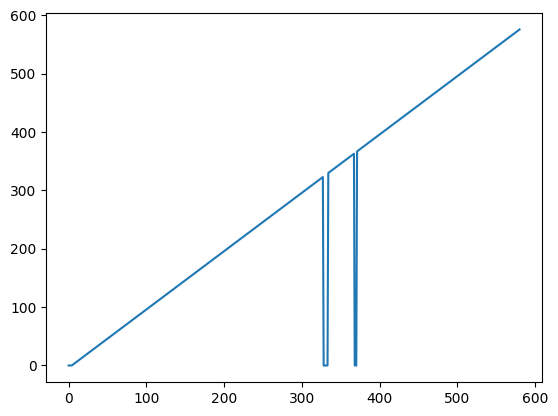

[325 365]


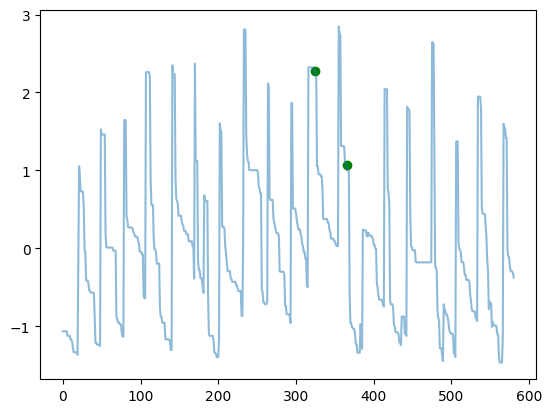

alpha0.01
beta1
kappa0.01
bank
F-Measure
0.5
Covering
0.5593803786574871


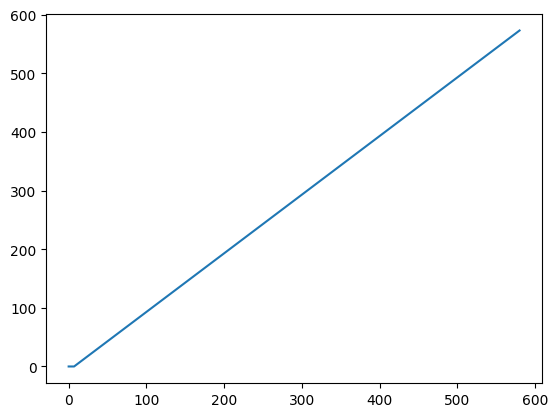

8
********************************


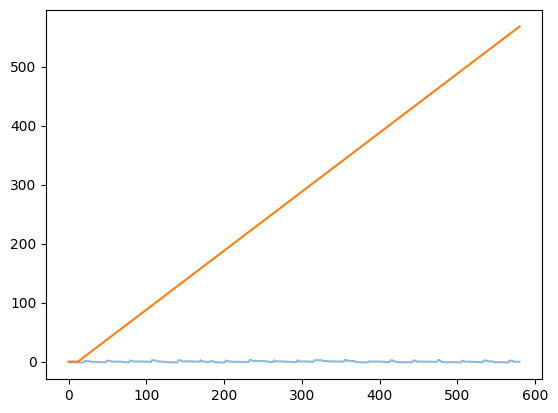

13
********************************


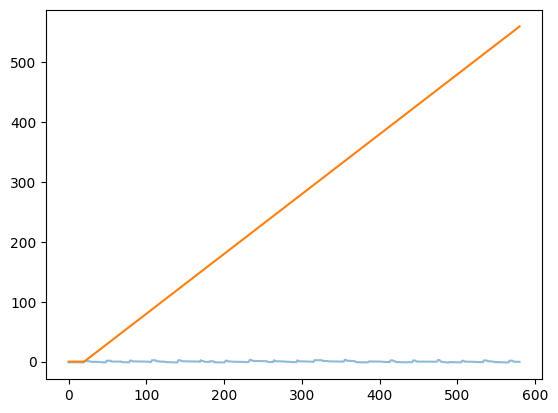

21
********************************


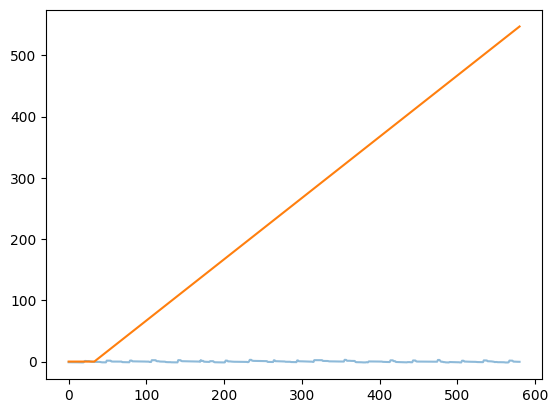

34
********************************


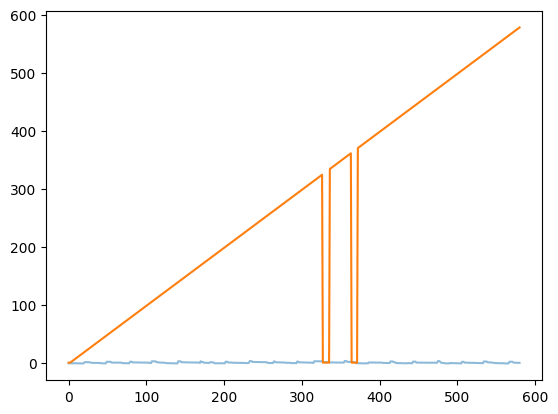

[325 362]


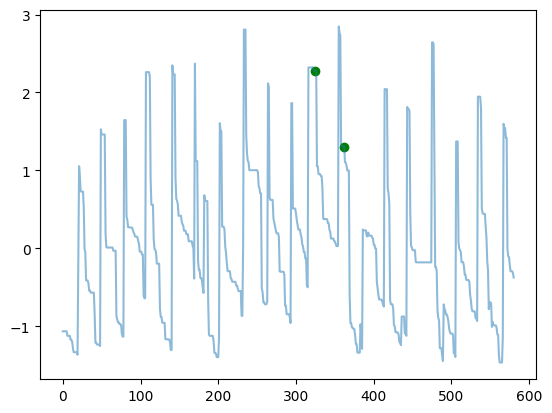

alpha0.01
beta1
kappa1
bank
F-Measure
0.5
Covering
0.5593803786574871


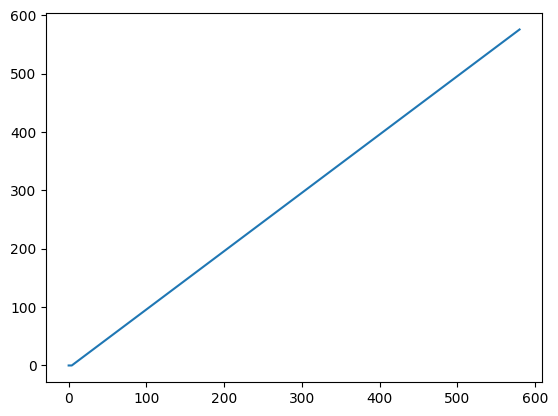

5
********************************


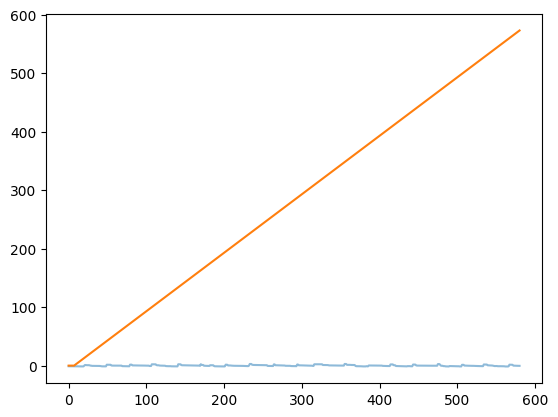

8
********************************


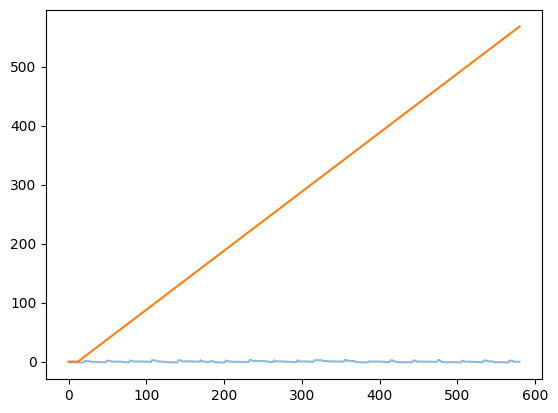

13
********************************


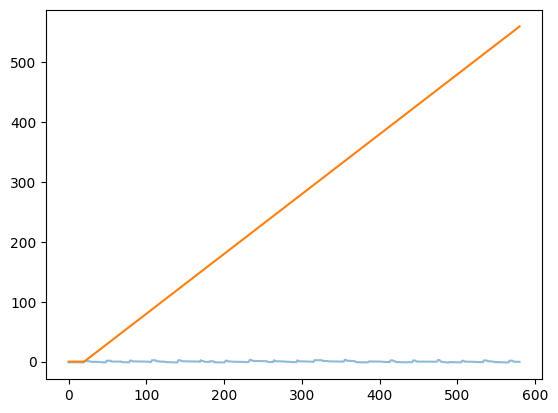

21
********************************


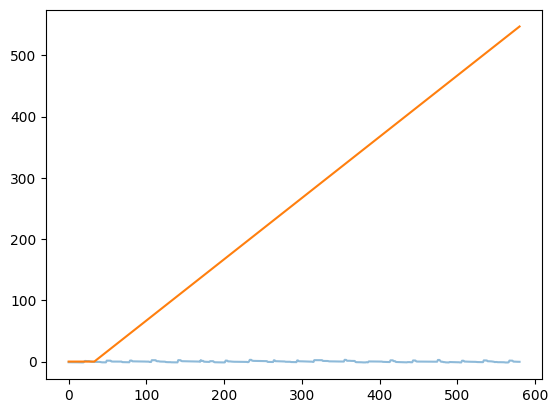

34
********************************


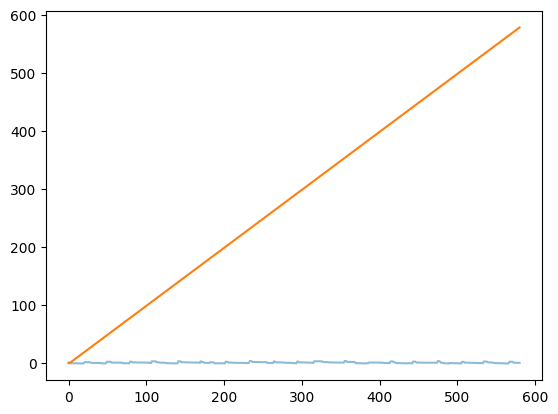

3
********************************


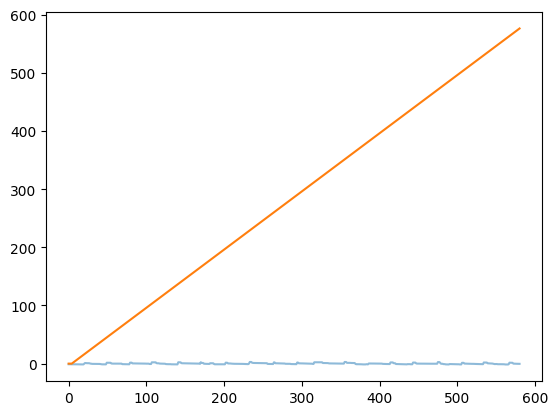

5
********************************


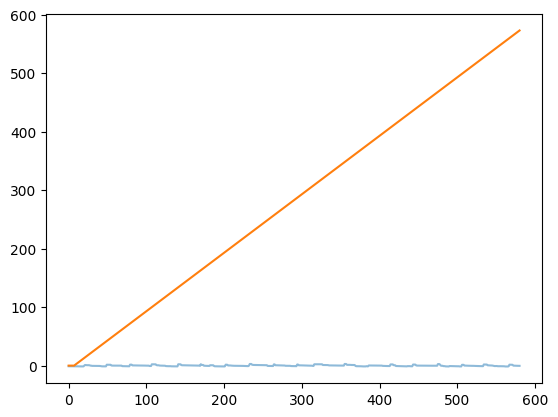

8
********************************


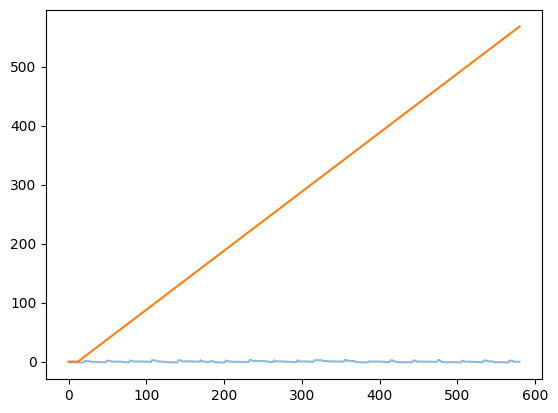

13
********************************


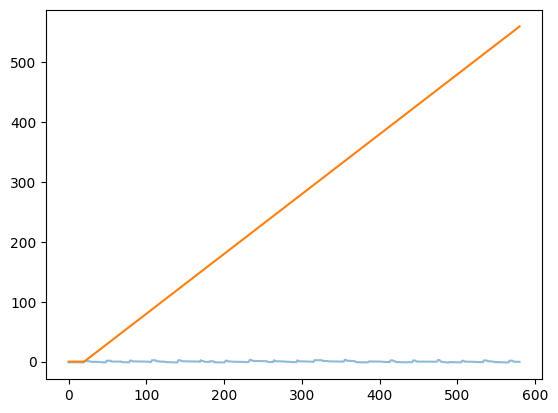

21
********************************


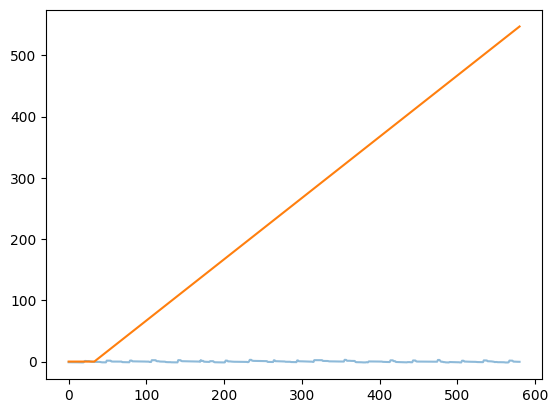

34
********************************


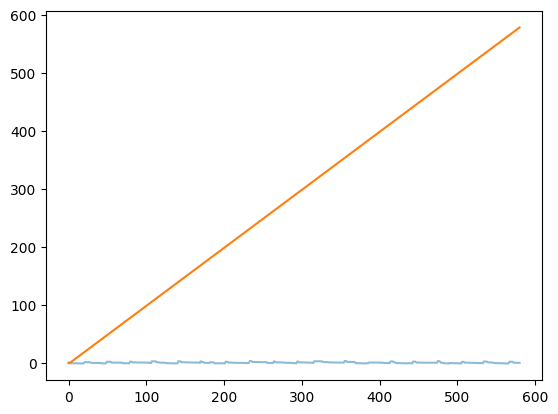

3
********************************


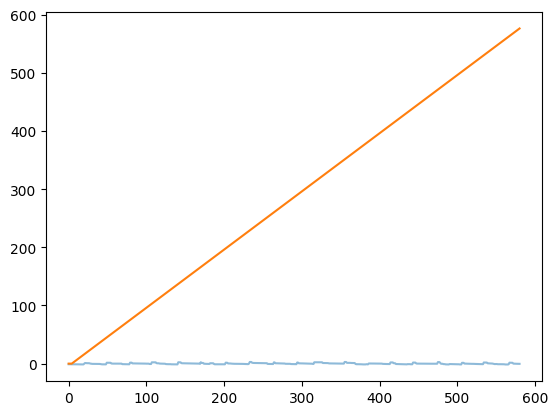

5
********************************


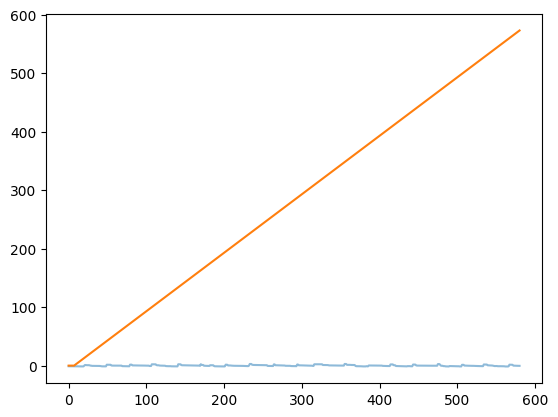

8
********************************


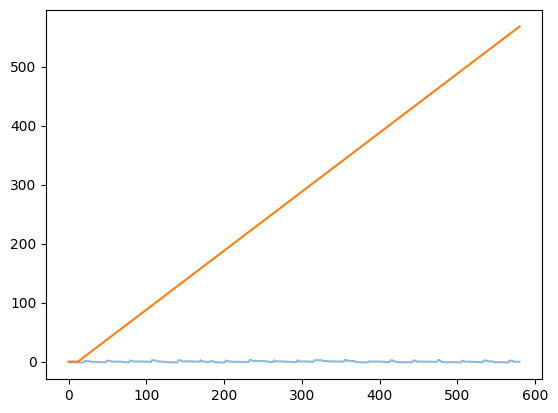

13
********************************


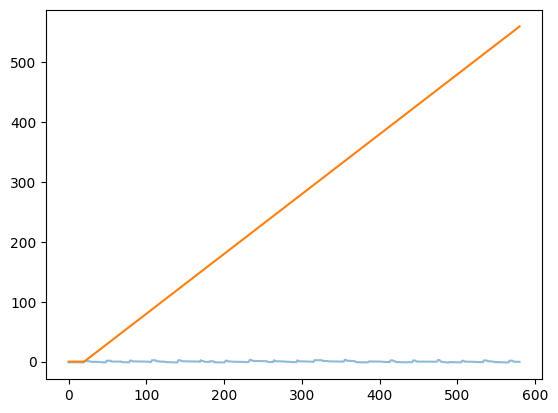

21
********************************


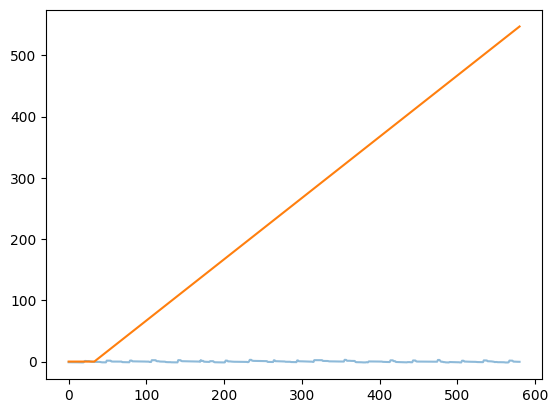

34
********************************


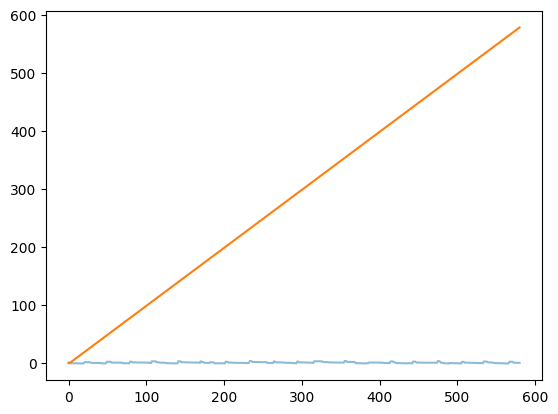

3
********************************


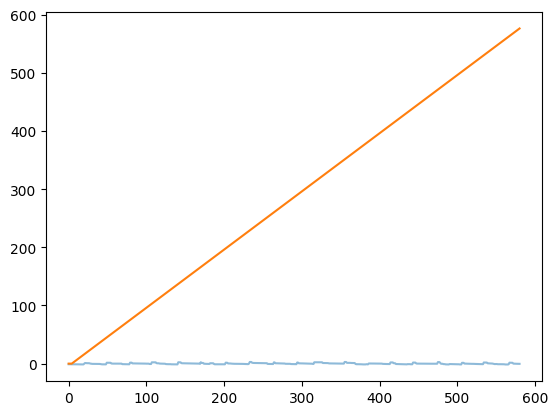

5
********************************


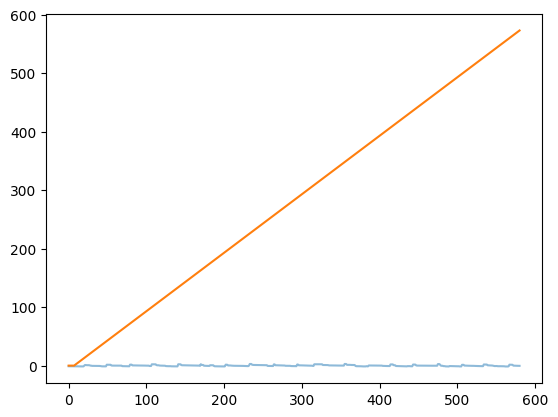

8
********************************


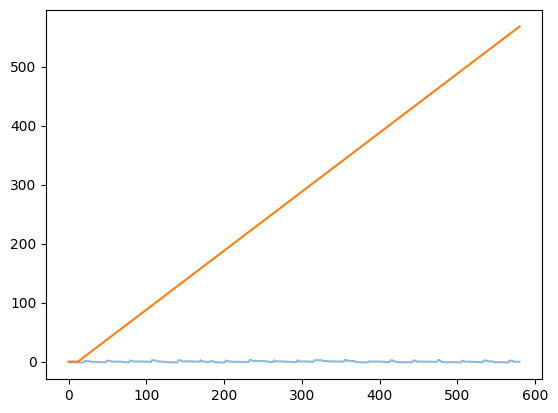

13
********************************


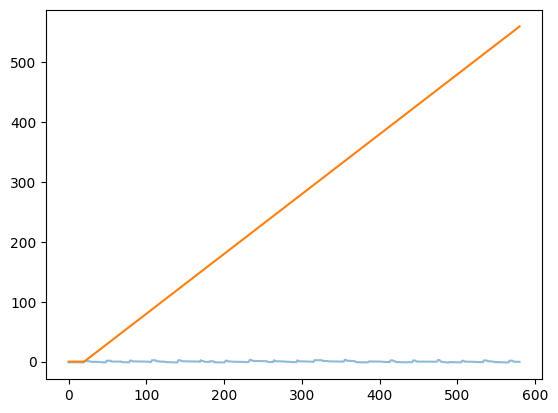

21
********************************


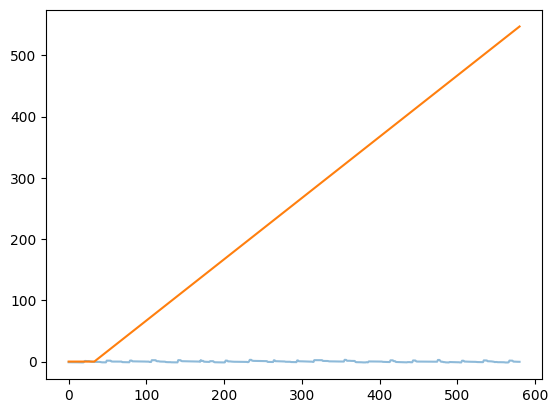

34
********************************


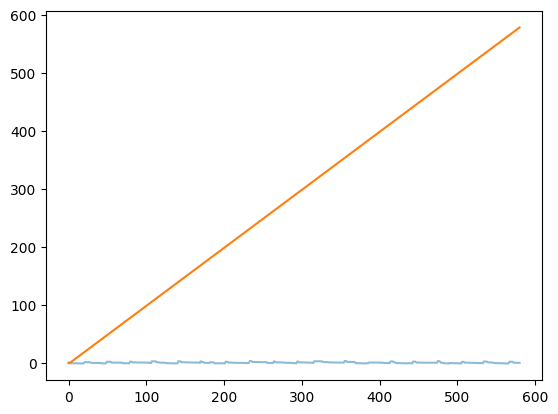

3
********************************


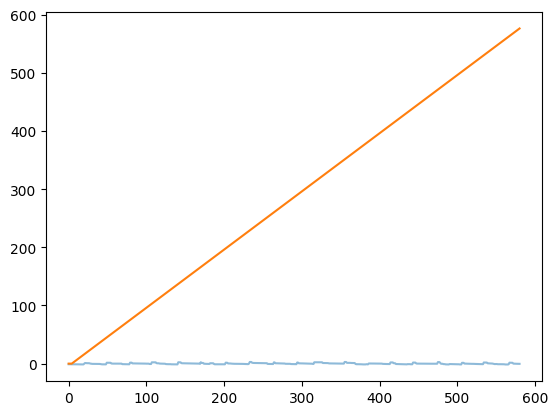

5
********************************


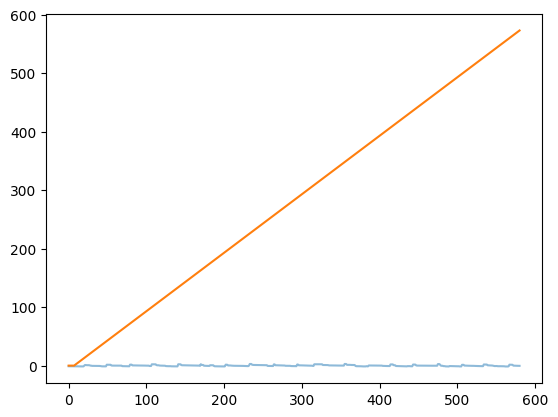

8
********************************


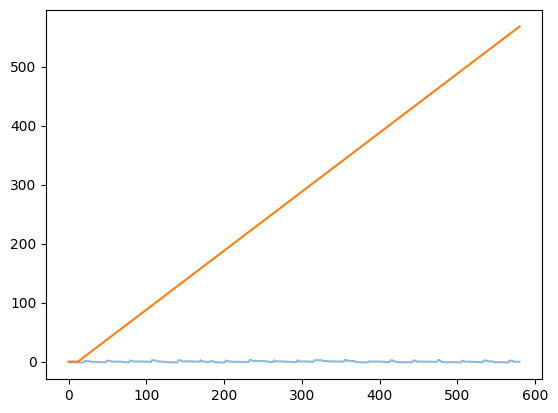

13
********************************


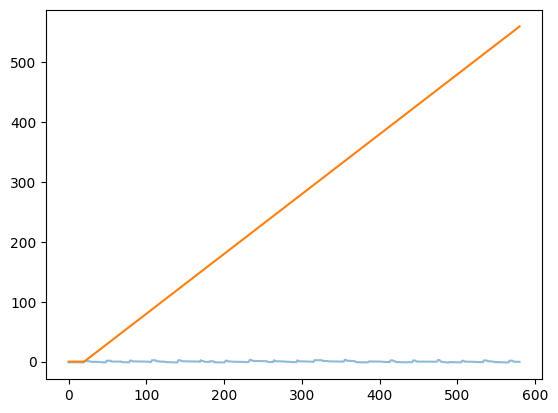

21
********************************


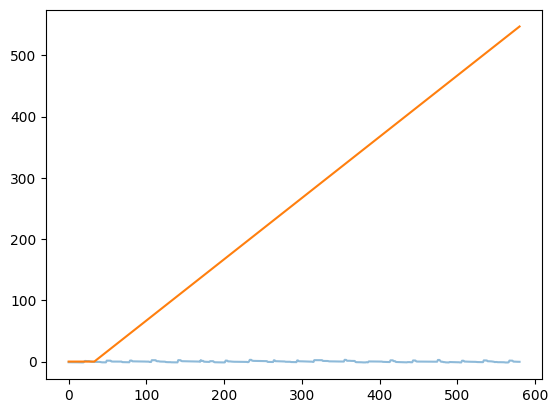

34
********************************


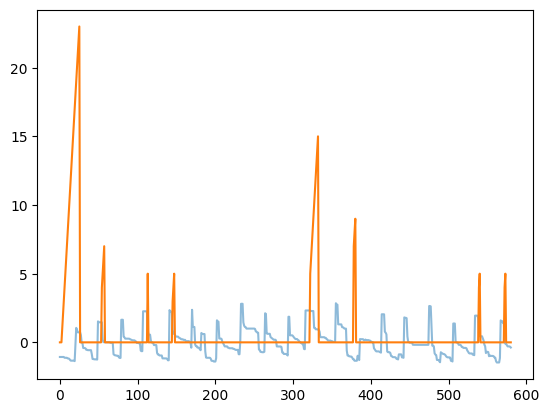

[ 24 331]


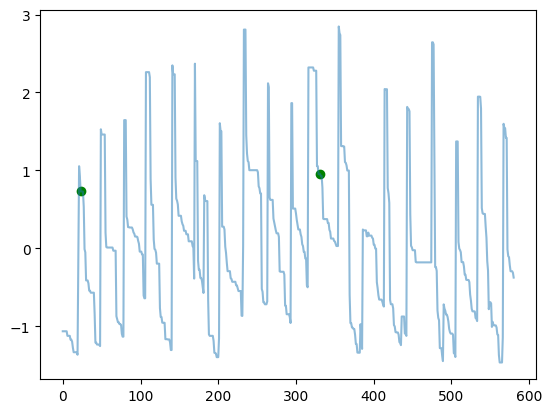

alpha1
beta0.01
kappa0.01
bank
F-Measure
0.5
Covering
0.5283993115318416


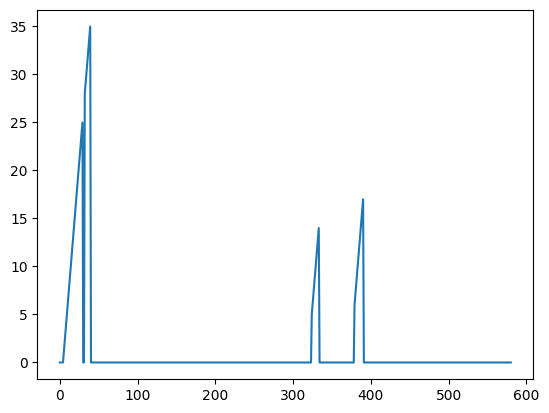

[ 27  37 331 388]


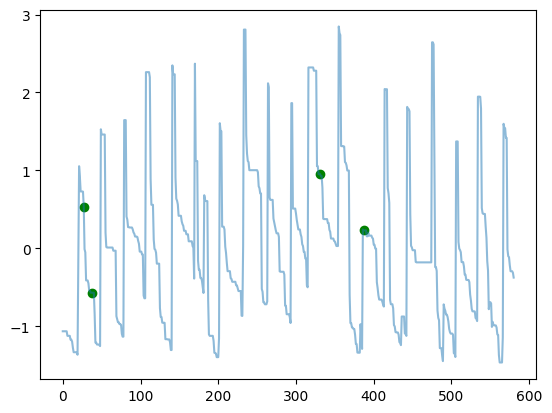

alpha1
beta0.01
kappa0.01
bank
F-Measure
0.33333333333333337
Covering
0.5060240963855421


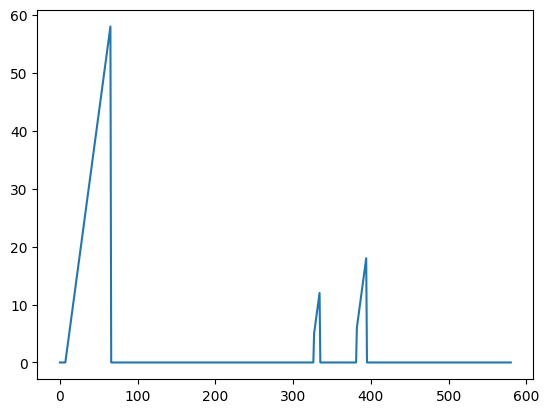

[ 61 330 390]


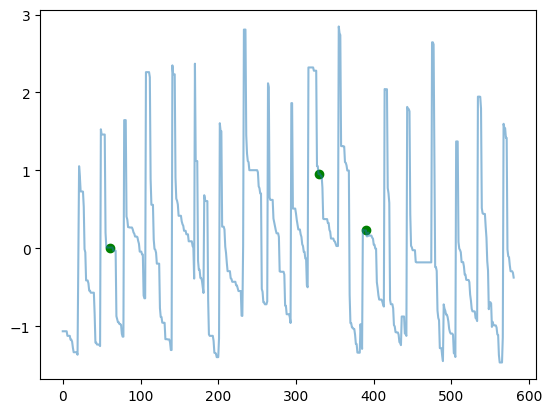

alpha1
beta0.01
kappa0.01
bank
F-Measure
0.4
Covering
0.4629948364888124


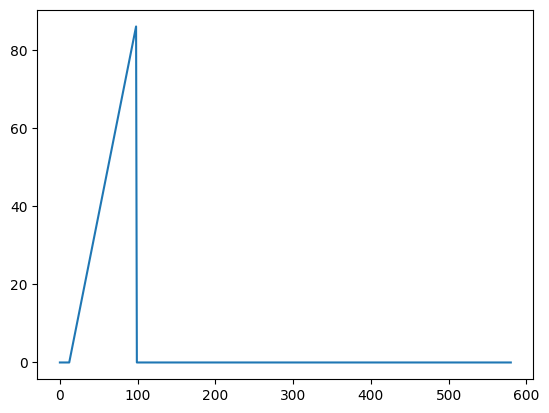

[92]


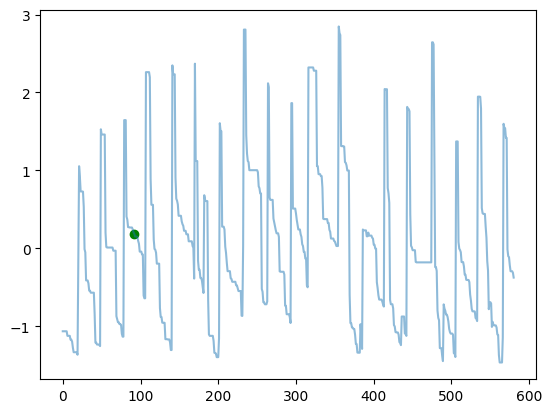

alpha1
beta0.01
kappa0.01
bank
F-Measure
0.6666666666666666
Covering
0.8416523235800344


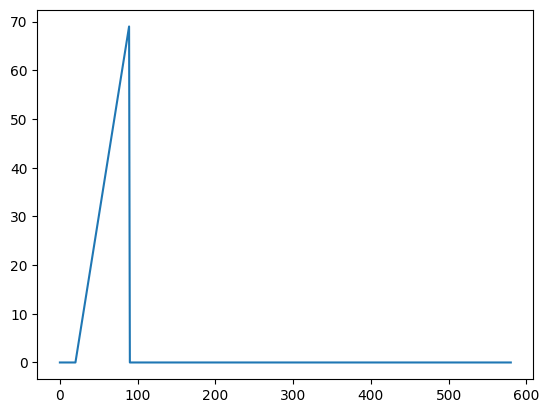

[79]


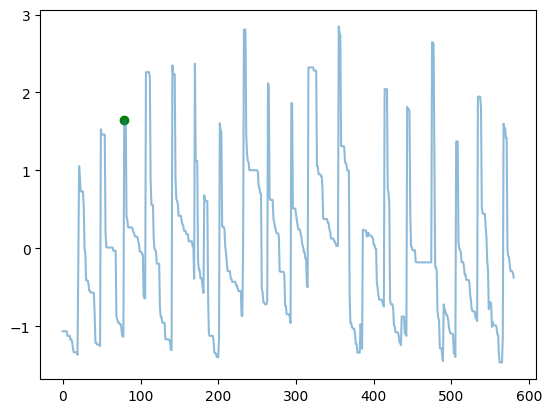

alpha1
beta0.01
kappa0.01
bank
F-Measure
0.6666666666666666
Covering
0.8640275387263339


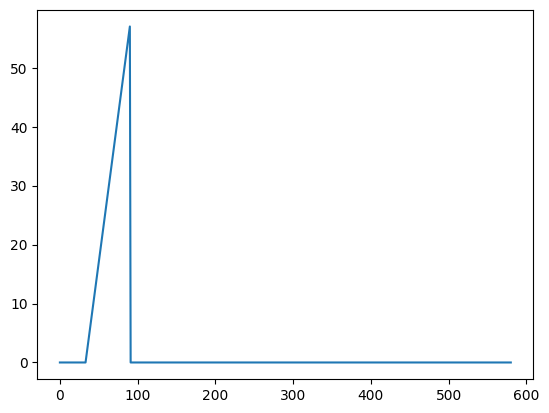

[73]


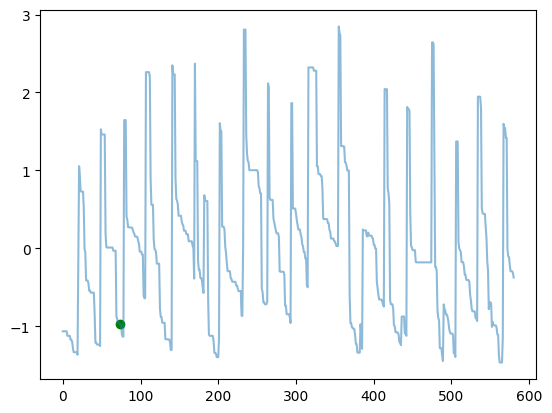

alpha1
beta0.01
kappa0.01
bank
F-Measure
0.6666666666666666
Covering
0.8743545611015492


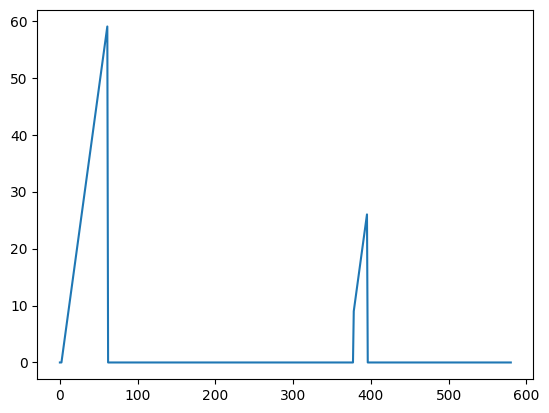

[ 60 394]


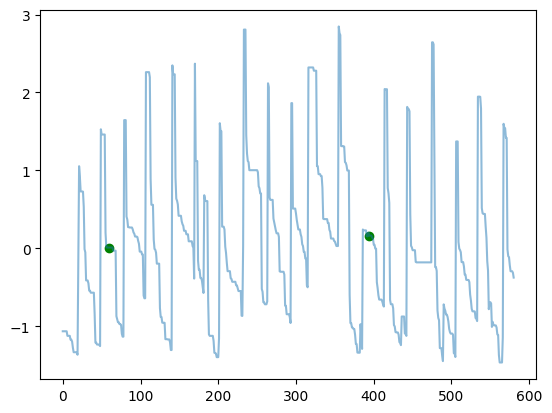

alpha1
beta0.01
kappa1
bank
F-Measure
0.5
Covering
0.5748709122203098


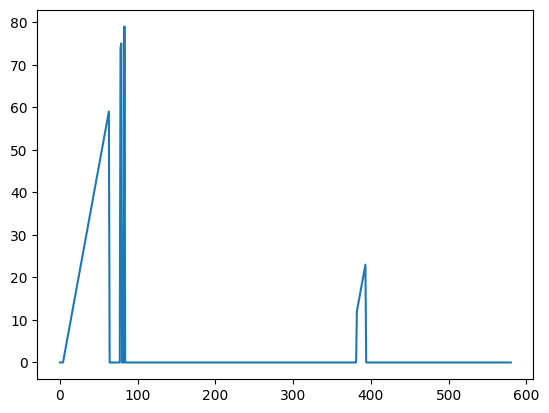

[ 61  77  81 391]


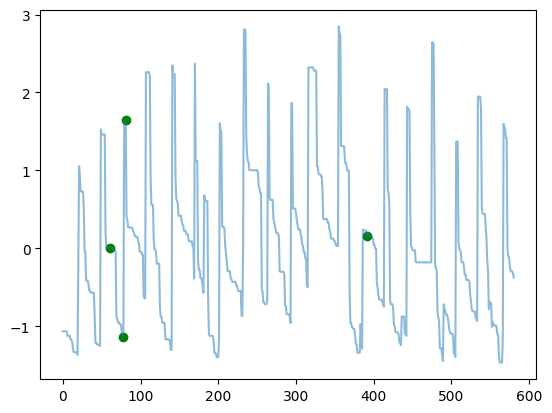

alpha1
beta0.01
kappa1
bank
F-Measure
0.33333333333333337
Covering
0.5335628227194492


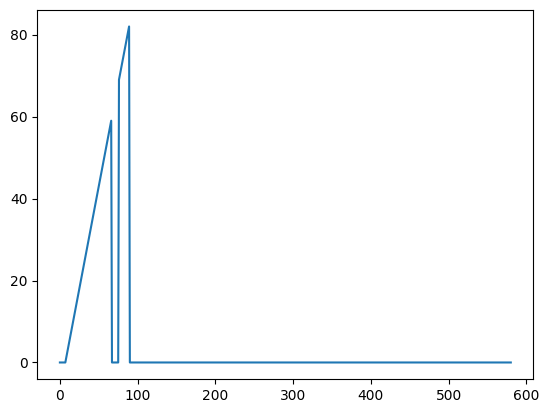

[62 85]


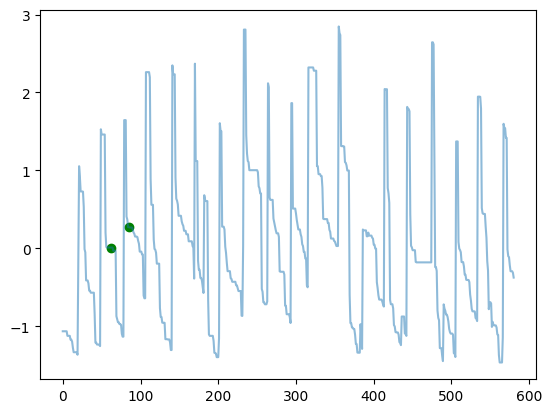

alpha1
beta0.01
kappa1
bank
F-Measure
0.5
Covering
0.8537005163511188


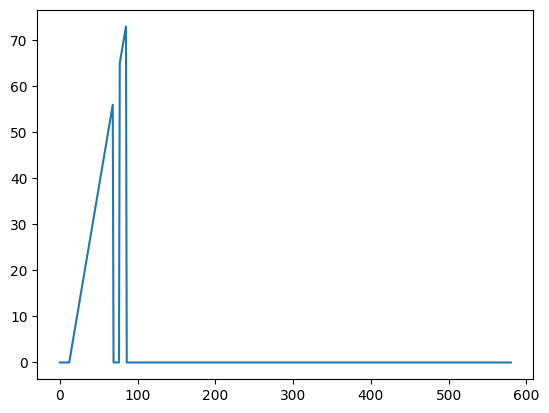

[62 79]


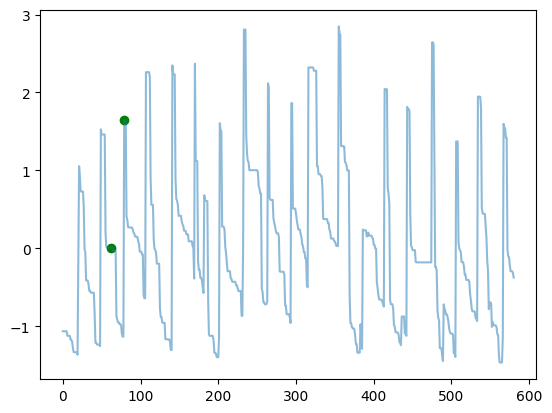

alpha1
beta0.01
kappa1
bank
F-Measure
0.5
Covering
0.8640275387263339


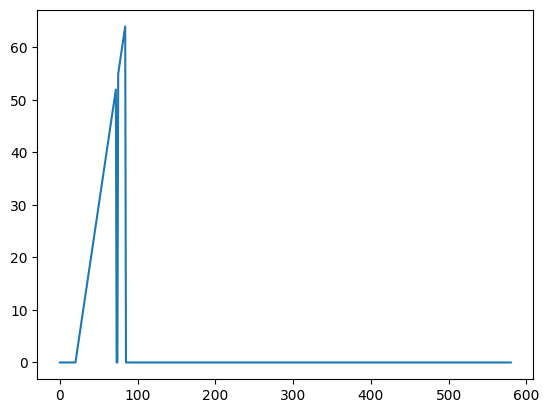

[62 74]


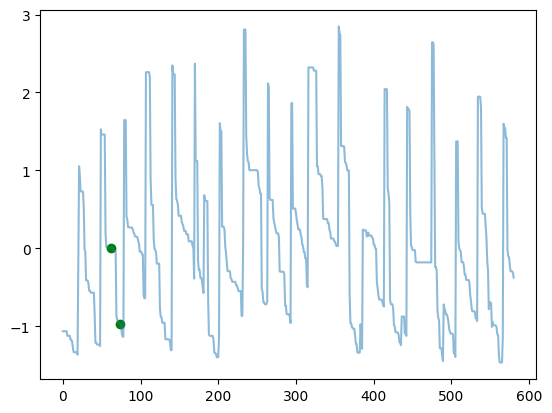

alpha1
beta0.01
kappa1
bank
F-Measure
0.5
Covering
0.87263339070568


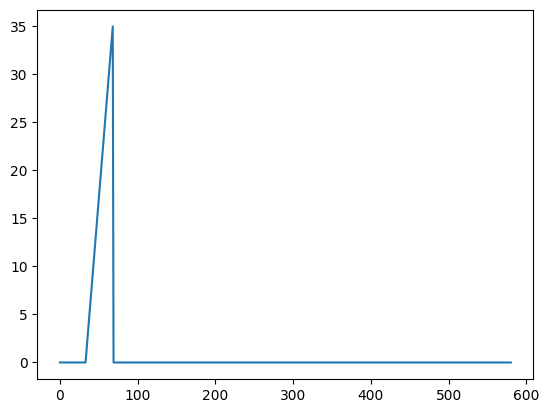

[51]


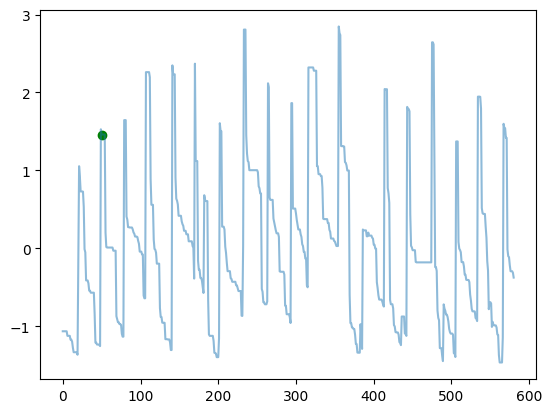

alpha1
beta0.01
kappa1
bank
F-Measure
0.6666666666666666
Covering
0.9122203098106713


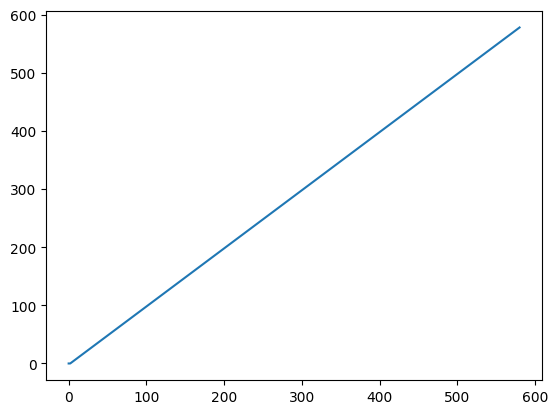

3
********************************


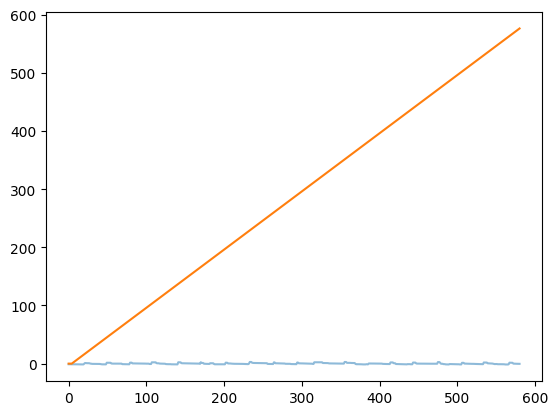

5
********************************


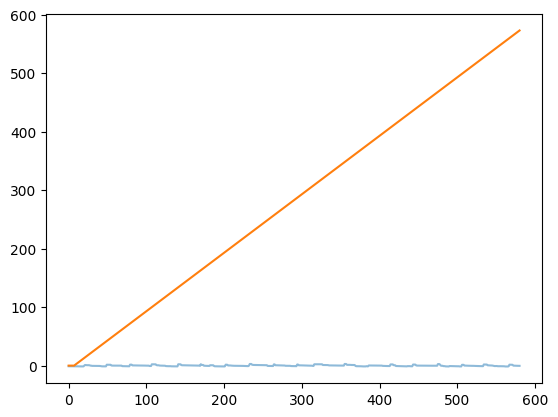

8
********************************


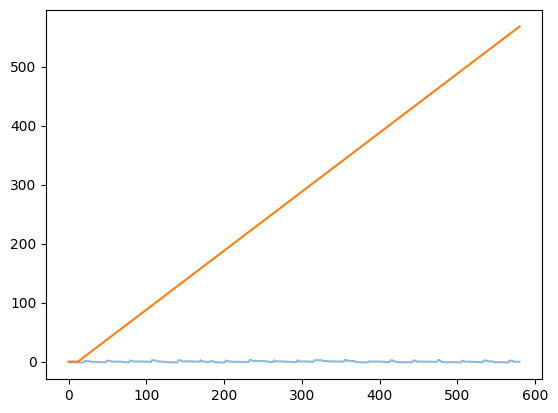

13
********************************


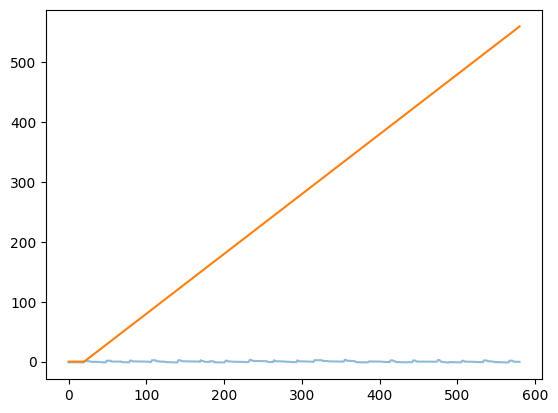

21
********************************


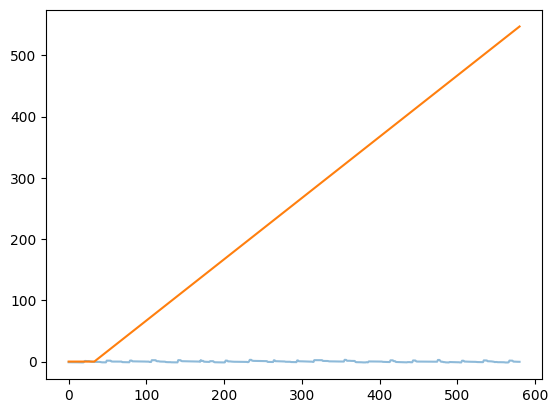

34
********************************


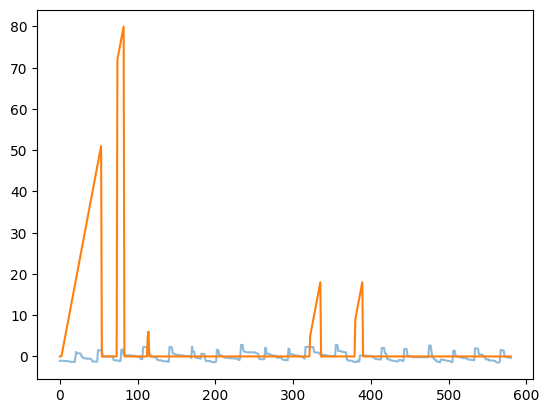

[ 52  81 334 388]


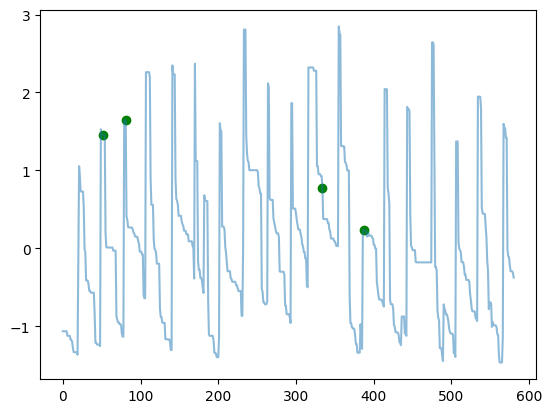

alpha1
beta1
kappa0.01
bank
F-Measure
0.33333333333333337
Covering
0.4354561101549053


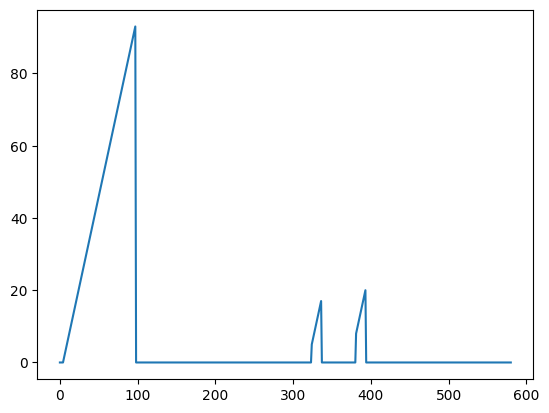

[ 95 334 391]


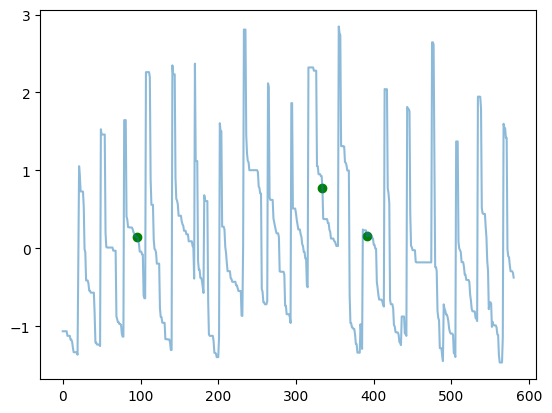

alpha1
beta1
kappa0.01
bank
F-Measure
0.4
Covering
0.4113597246127367


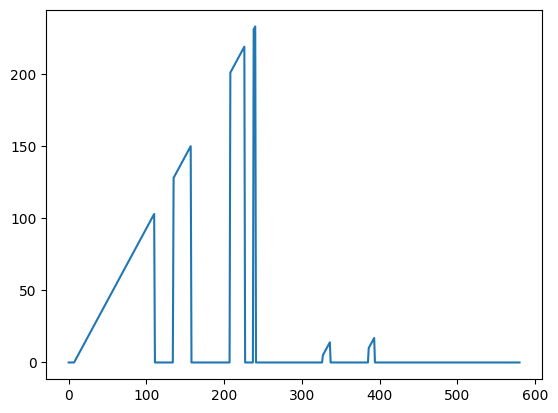

[106 153 222 236 332 389]


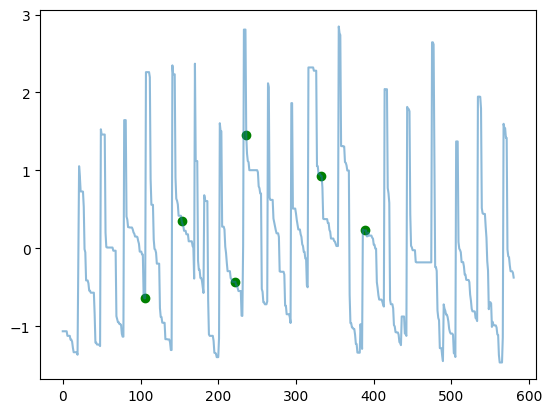

alpha1
beta1
kappa0.01
bank
F-Measure
0.25
Covering
0.3304647160068847


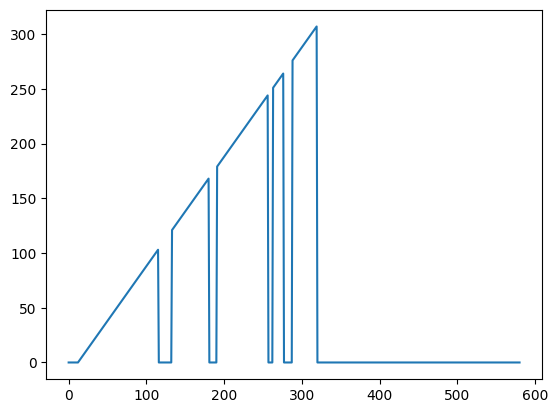

[109 174 250 270 313]


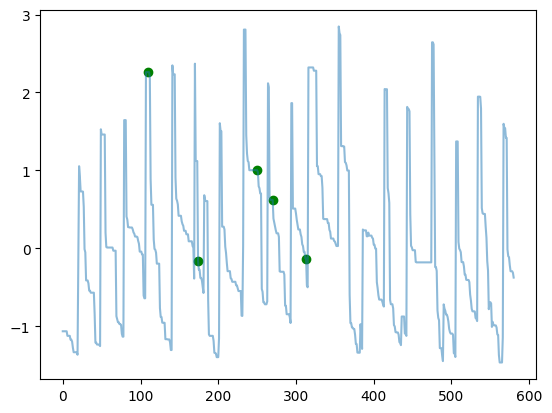

alpha1
beta1
kappa0.01
bank
F-Measure
0.2857142857142857
Covering
0.4612736660929432


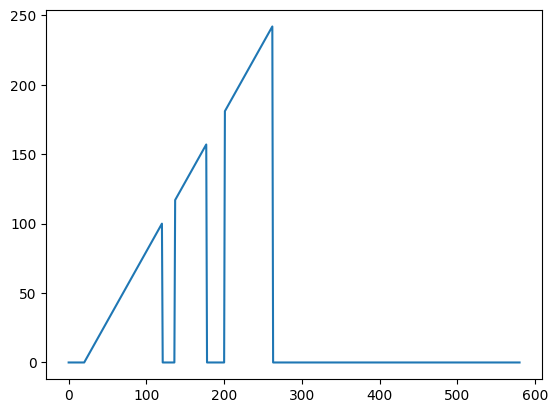

[110 167 252]


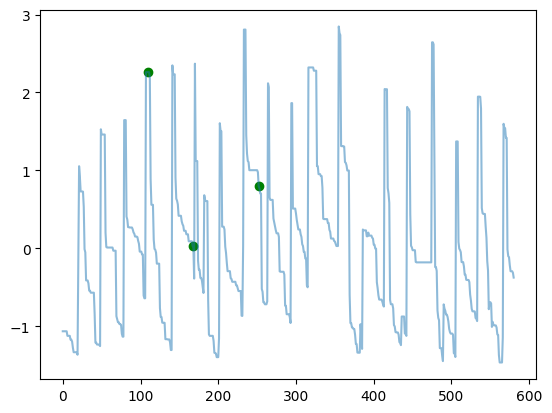

alpha1
beta1
kappa0.01
bank
F-Measure
0.4
Covering
0.5662650602409639


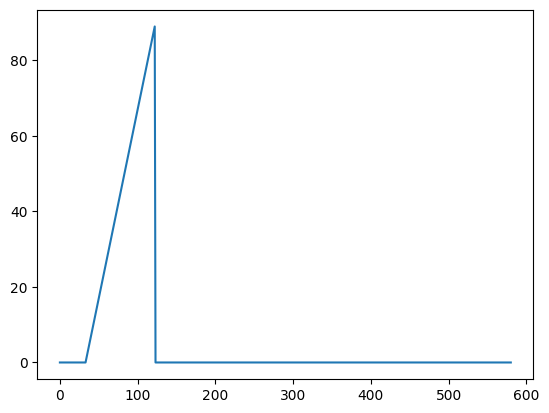

[105]


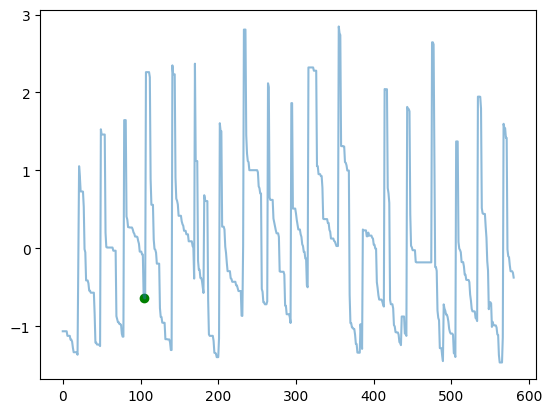

alpha1
beta1
kappa0.01
bank
F-Measure
0.6666666666666666
Covering
0.8192771084337348


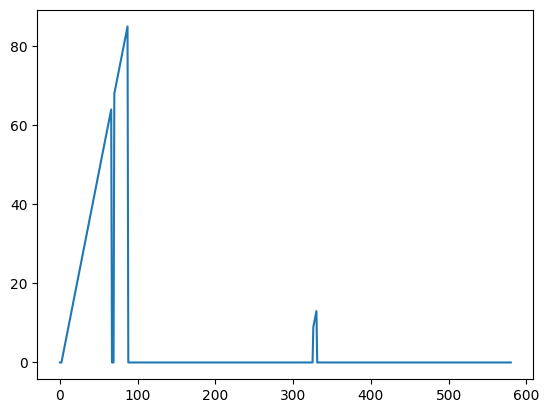

[ 65  86 329]


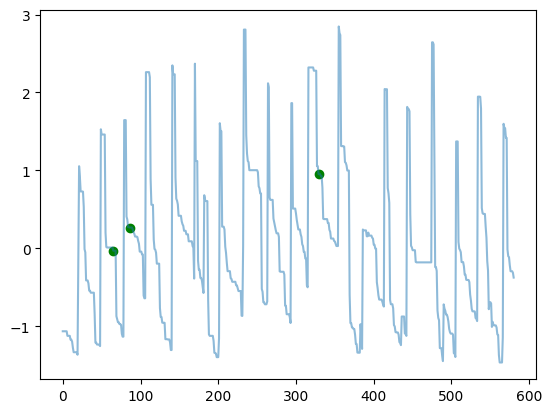

alpha1
beta1
kappa1
bank
F-Measure
0.4
Covering
0.4337349397590361


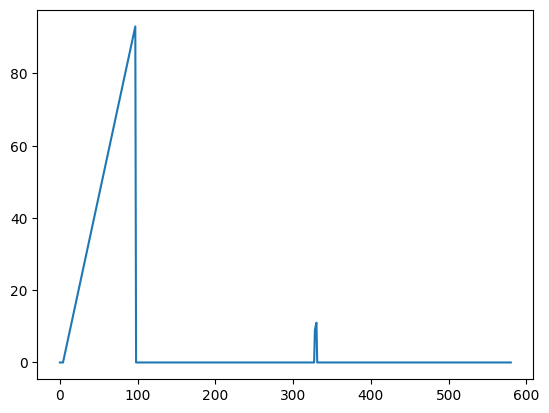

[95]


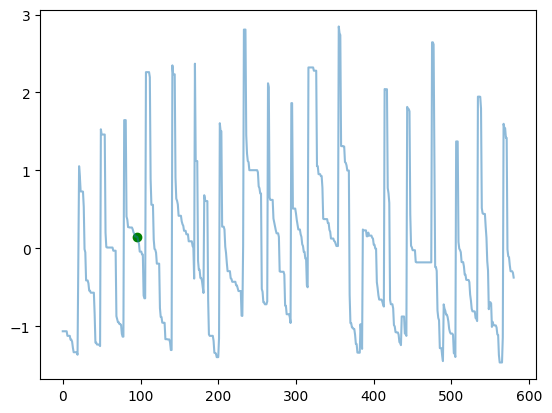

alpha1
beta1
kappa1
bank
F-Measure
0.6666666666666666
Covering
0.8364888123924269


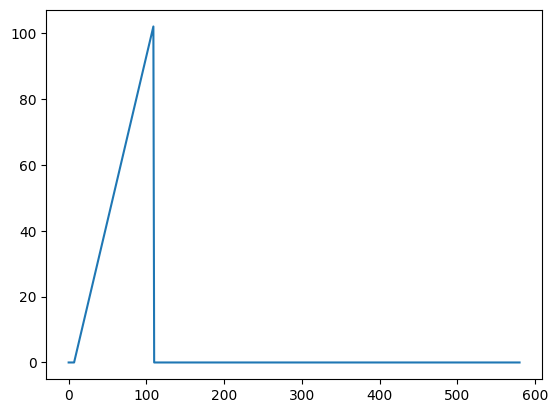

[105]


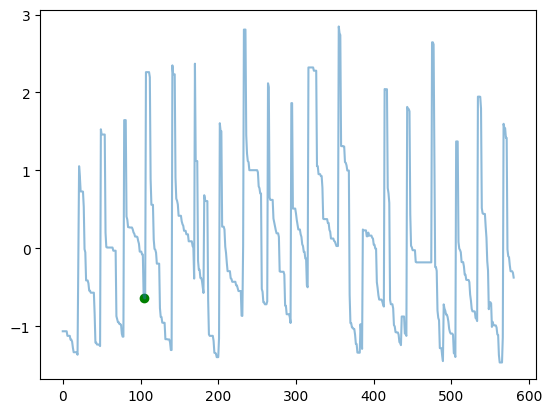

alpha1
beta1
kappa1
bank
F-Measure
0.6666666666666666
Covering
0.8192771084337348


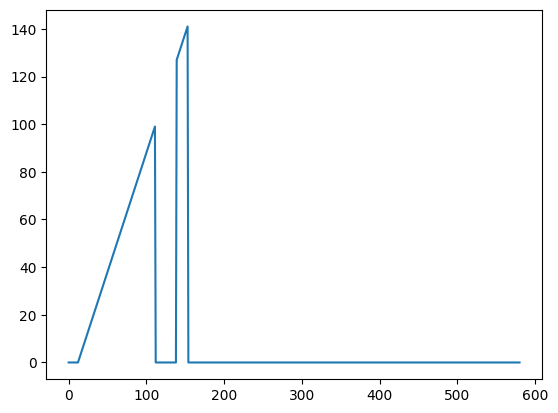

[105 147]


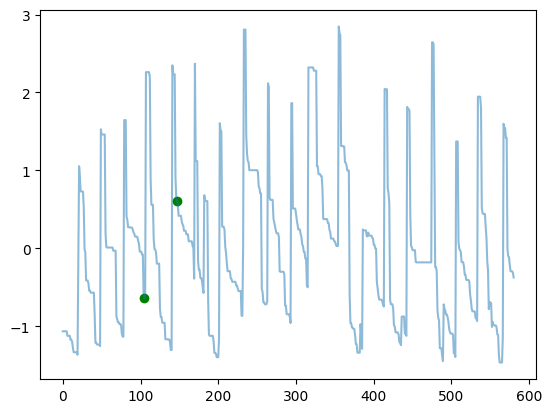

alpha1
beta1
kappa1
bank
F-Measure
0.5
Covering
0.7469879518072289


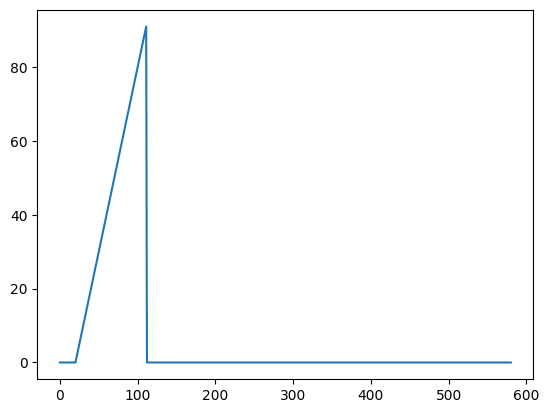

[101]


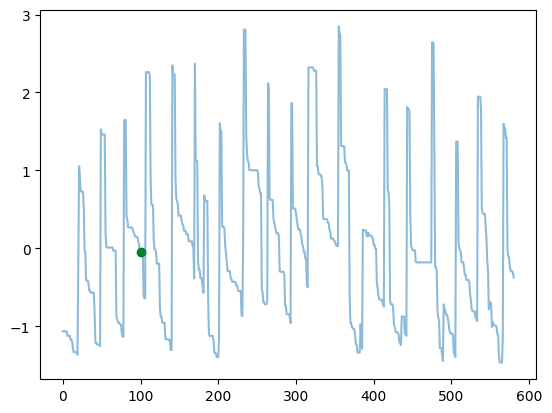

alpha1
beta1
kappa1
bank
F-Measure
0.6666666666666666
Covering
0.8261617900172118


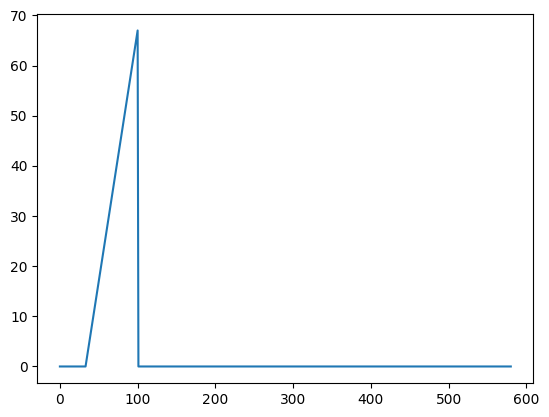

[83]


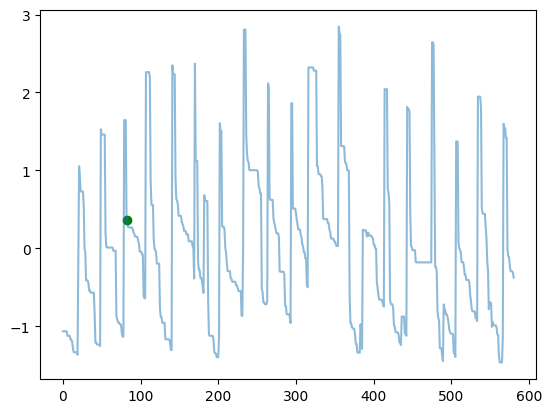

alpha1
beta1
kappa1
bank
F-Measure
0.6666666666666666
Covering
0.8571428571428571


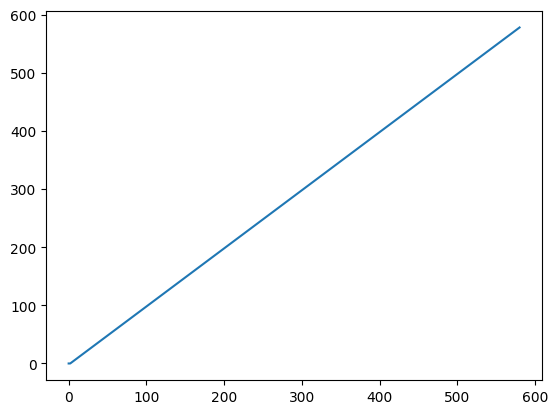

3
********************************


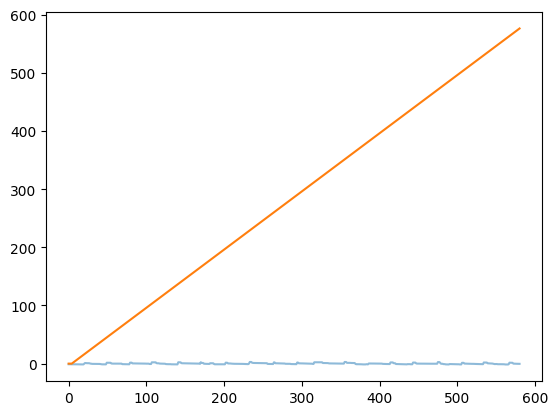

5
********************************


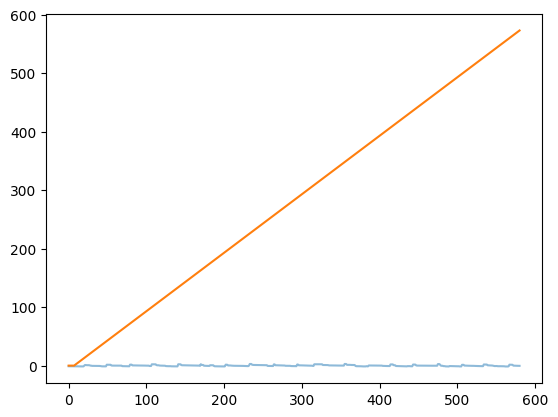

8
********************************


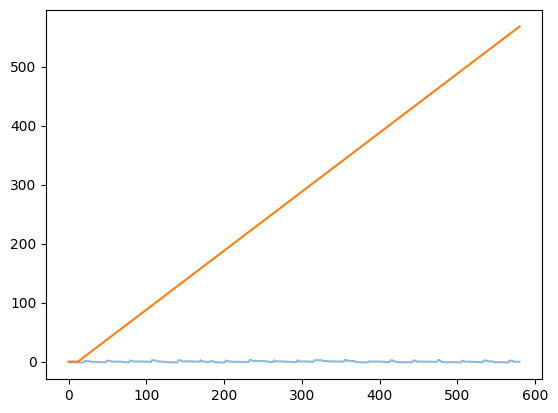

13
********************************


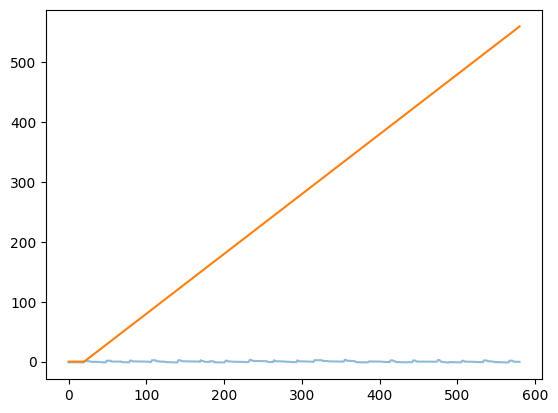

21
********************************


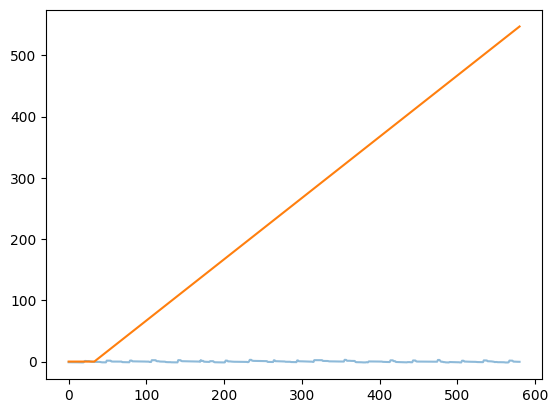

34
********************************


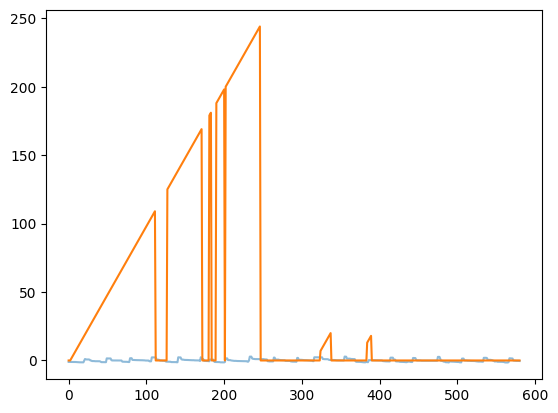

[110 170 182 199 245 336 388]


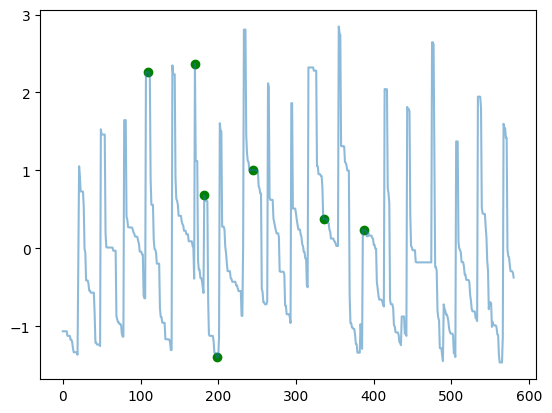

alpha1
beta100
kappa0.01
bank
F-Measure
0.2222222222222222
Covering
0.33218588640275387


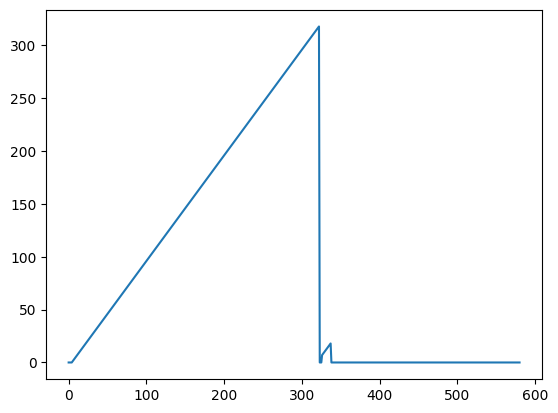

[320 335]


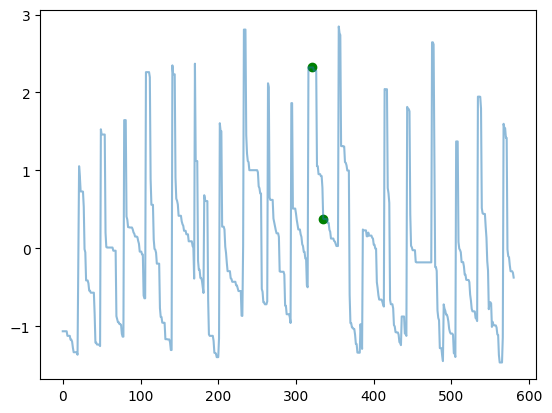

alpha1
beta100
kappa0.01
bank
F-Measure
0.5
Covering
0.5507745266781411


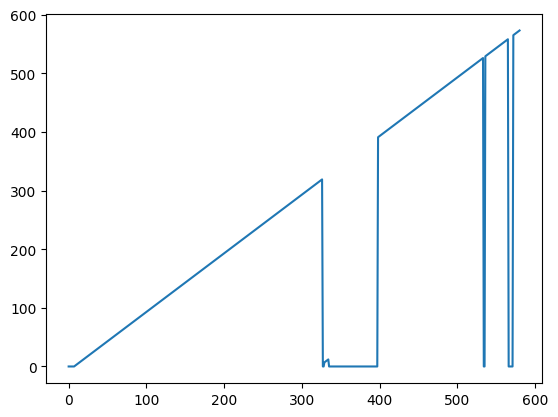

[322 330 529 561]


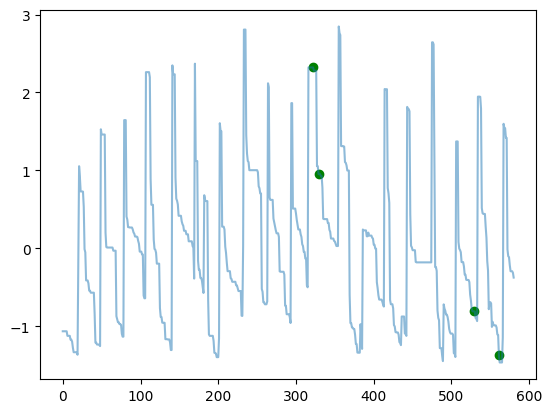

alpha1
beta100
kappa0.01
bank
F-Measure
0.33333333333333337
Covering
0.5542168674698795


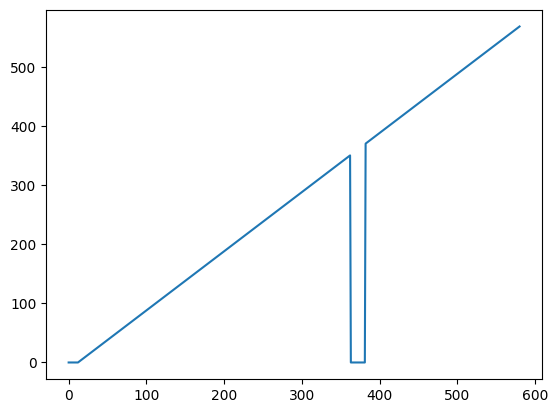

[356]


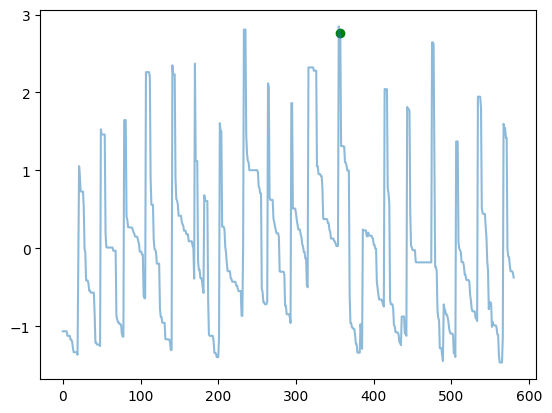

alpha1
beta100
kappa0.01
bank
F-Measure
0.6666666666666666
Covering
0.612736660929432


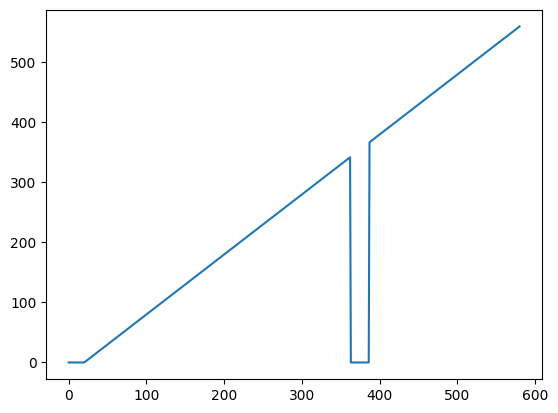

[352]


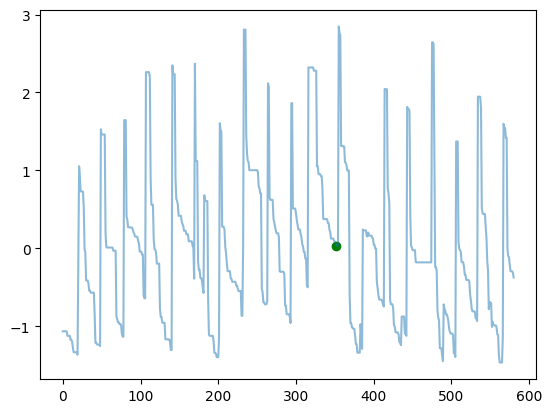

alpha1
beta100
kappa0.01
bank
F-Measure
0.6666666666666666
Covering
0.6058519793459552


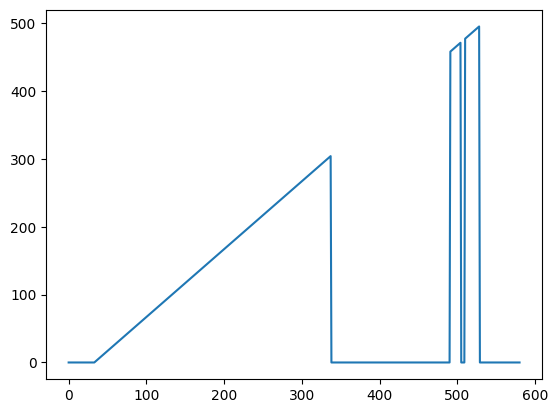

[320 487 511]


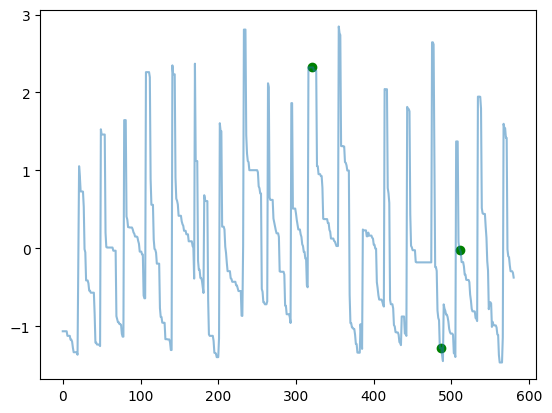

alpha1
beta100
kappa0.01
bank
F-Measure
0.4
Covering
0.5507745266781411


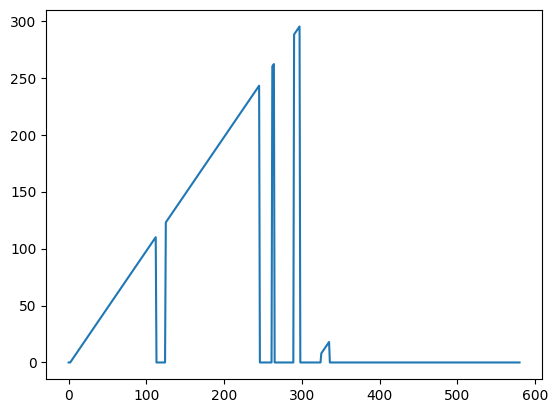

[111 244 263 296 334]


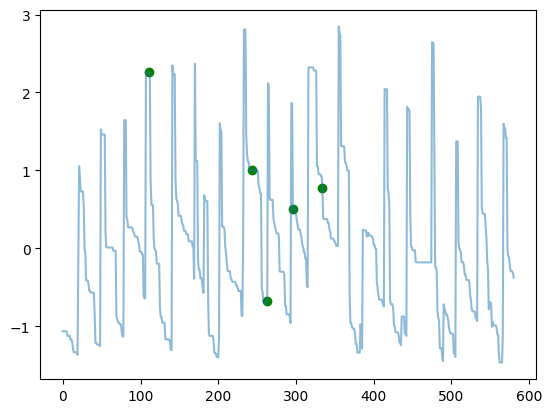

alpha1
beta100
kappa1
bank
F-Measure
0.2857142857142857
Covering
0.42512908777969016


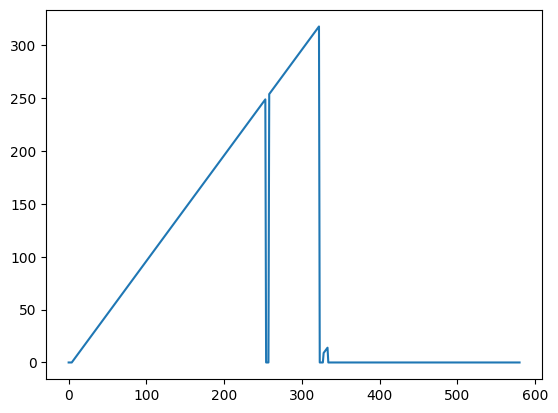

[251 320 331]


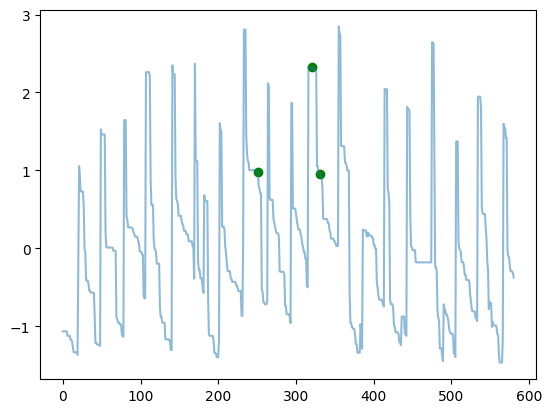

alpha1
beta100
kappa1
bank
F-Measure
0.4
Covering
0.43201376936316693


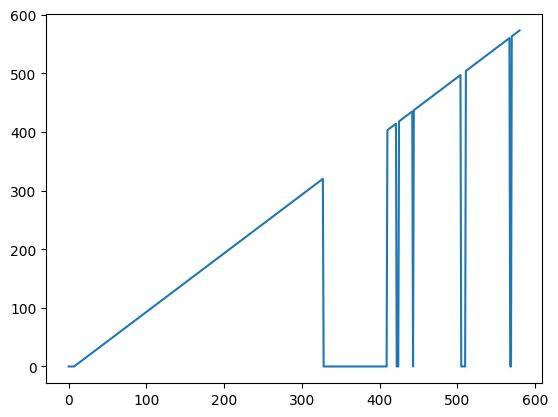

[323 417 438 500 563]


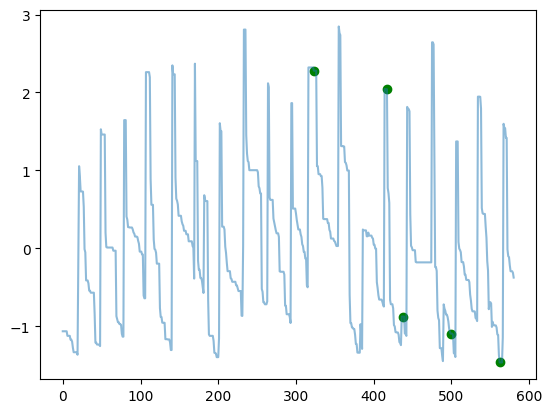

alpha1
beta100
kappa1
bank
F-Measure
0.2857142857142857
Covering
0.5559380378657487


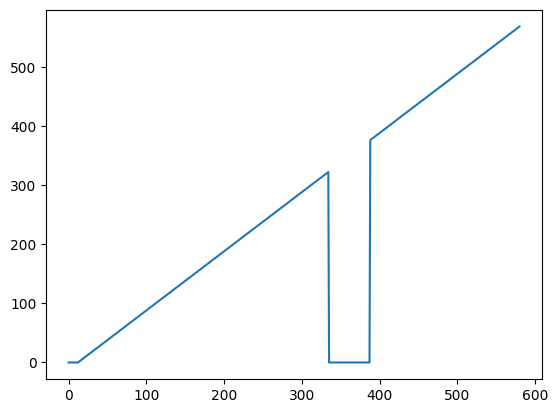

[328]


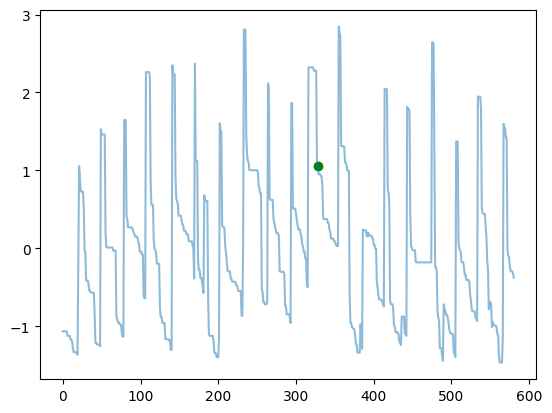

alpha1
beta100
kappa1
bank
F-Measure
0.6666666666666666
Covering
0.5645438898450946


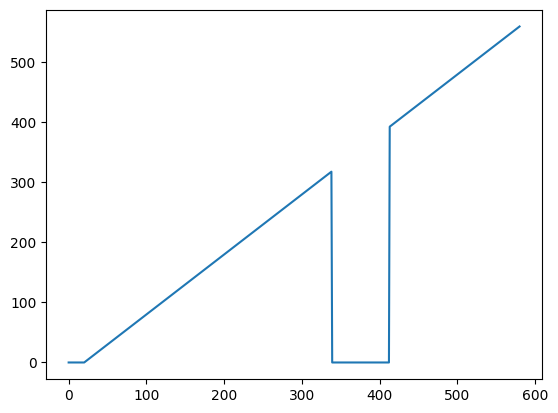

[328]


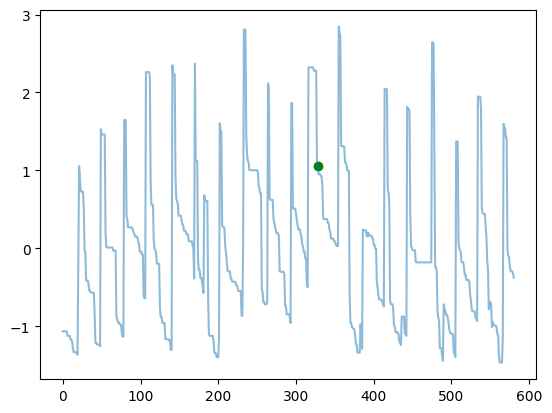

alpha1
beta100
kappa1
bank
F-Measure
0.6666666666666666
Covering
0.5645438898450946


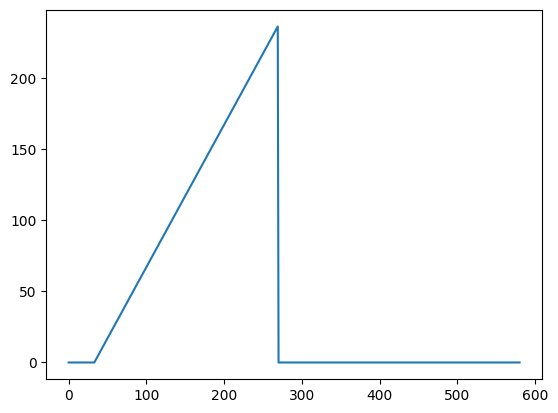

[252]


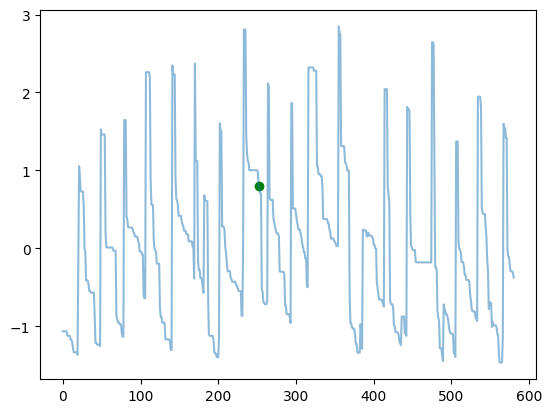

alpha1
beta100
kappa1
bank
F-Measure
0.6666666666666666
Covering
0.5662650602409639


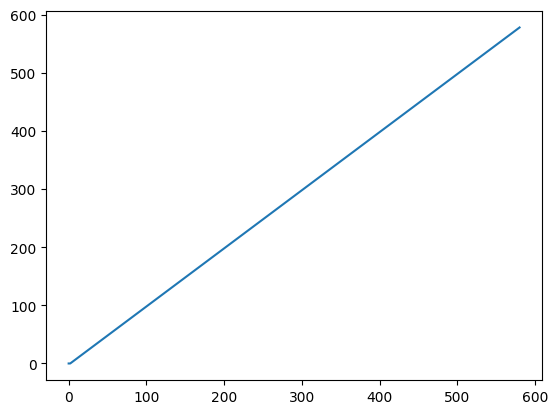

3
********************************


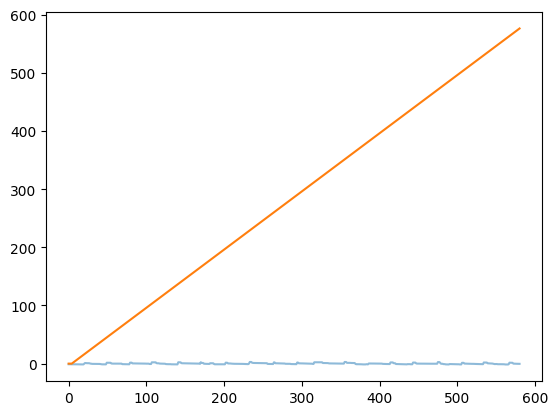

5
********************************


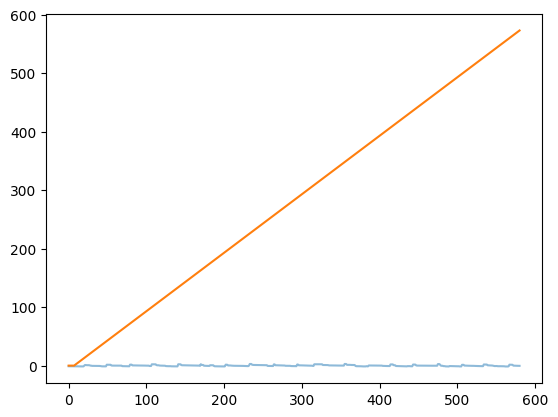

8
********************************


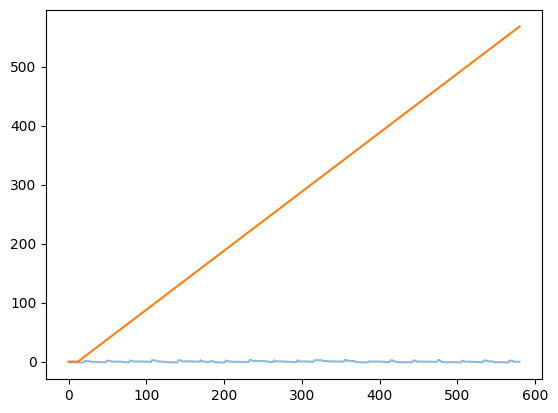

13
********************************


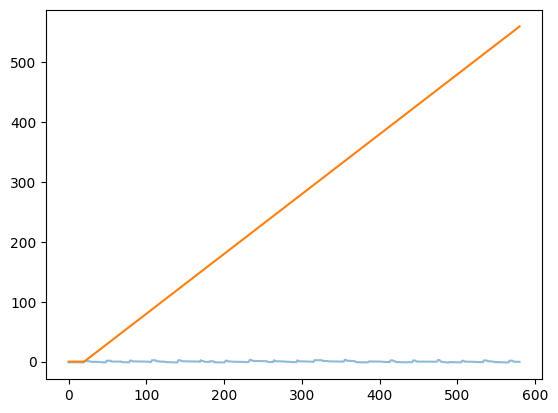

21
********************************


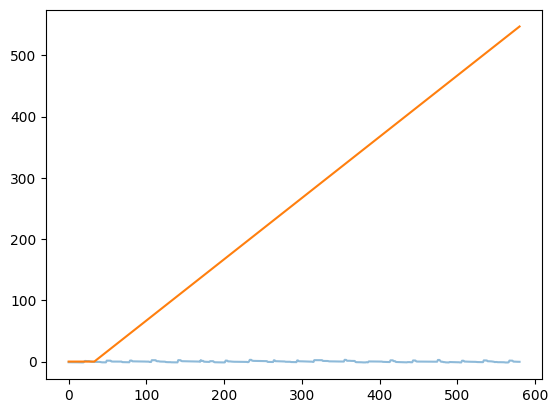

34
********************************


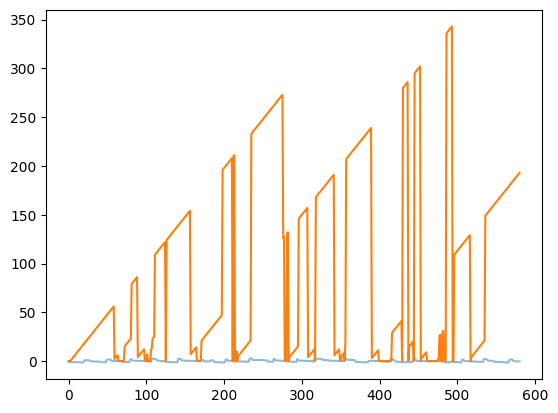

[ 57  87  96 123 155 163 209 212 274 276 281 306 315 340 347 388 427 435
 442 451 477 481 492 515]


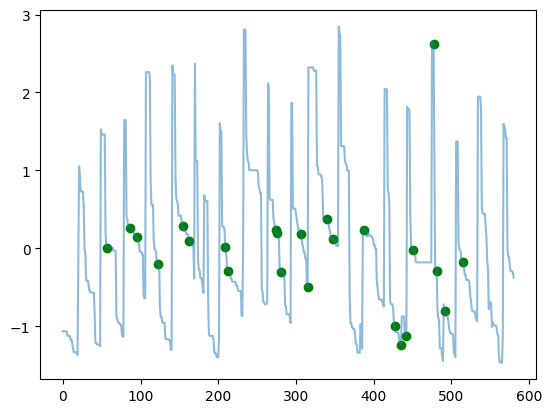

alpha100
beta0.01
kappa0.01
bank
F-Measure
0.07692307692307693
Covering
0.11359724612736662


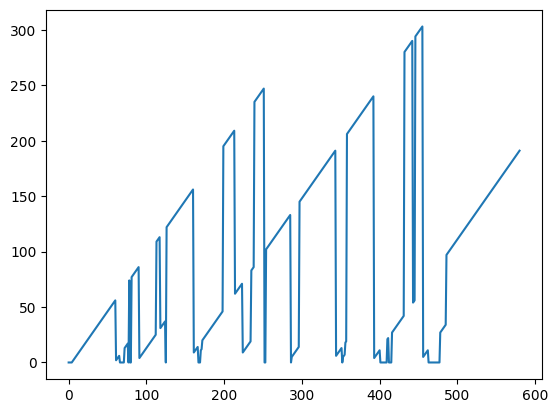

[ 58  74  76  88 115 122 158 164 211 221 249 283 341 349 390 409 440 453]


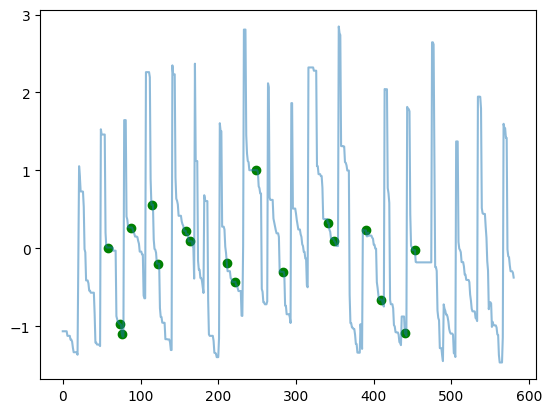

alpha100
beta0.01
kappa0.01
bank
F-Measure
0.1
Covering
0.2203098106712565


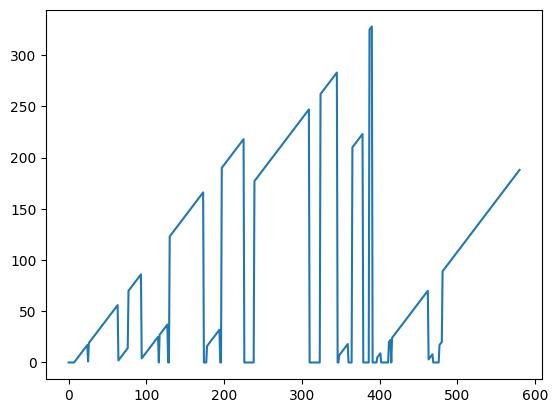

[ 20  59  89 111 123 169 190 221 305 341 355 374 386 410 458]


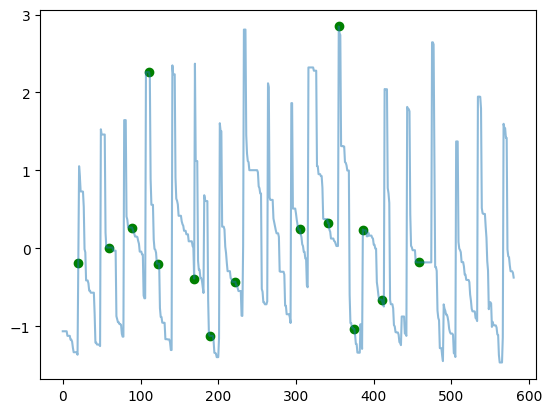

alpha100
beta0.01
kappa0.01
bank
F-Measure
0.11764705882352941
Covering
0.2117039586919105


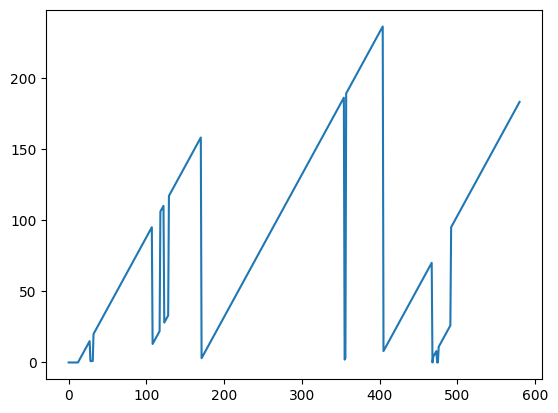

[ 21 101 116 164 348 398 461]


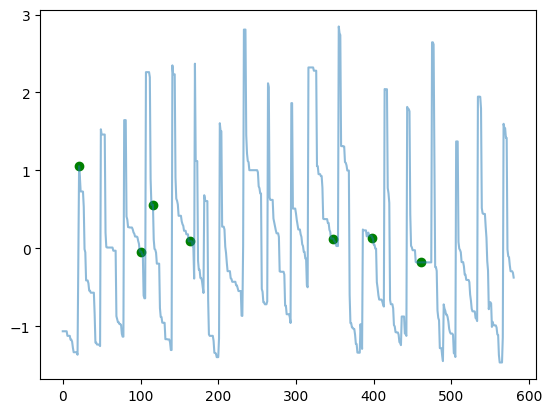

alpha100
beta0.01
kappa0.01
bank
F-Measure
0.2222222222222222
Covering
0.31669535283993117


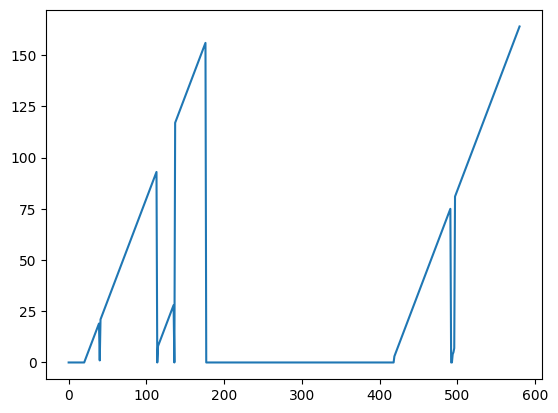

[ 29 103 125 166 481]


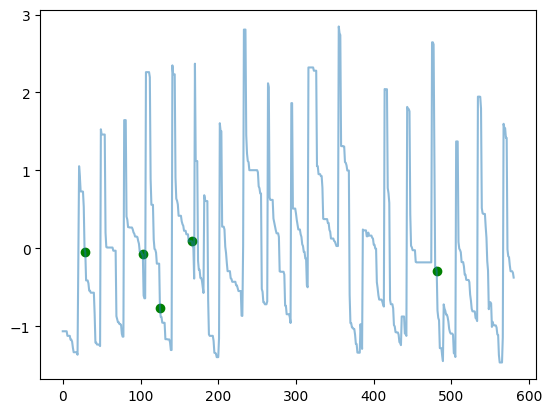

alpha100
beta0.01
kappa0.01
bank
F-Measure
0.2857142857142857
Covering
0.5421686746987951


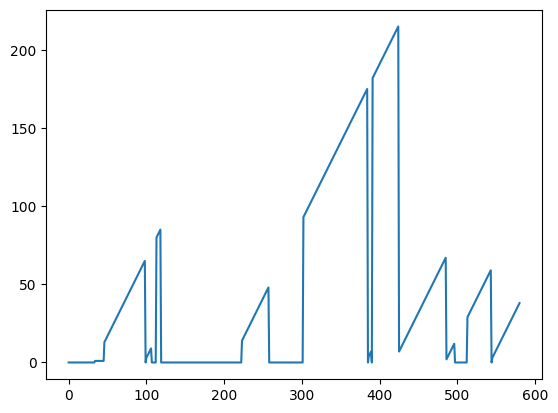

[ 81 101 240 367 407 468 479 526]


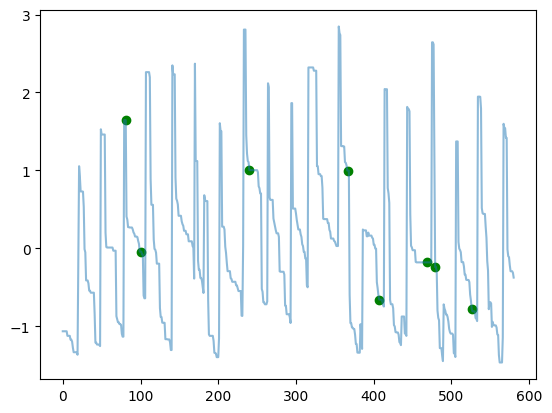

alpha100
beta0.01
kappa0.01
bank
F-Measure
0.19999999999999998
Covering
0.23924268502581753


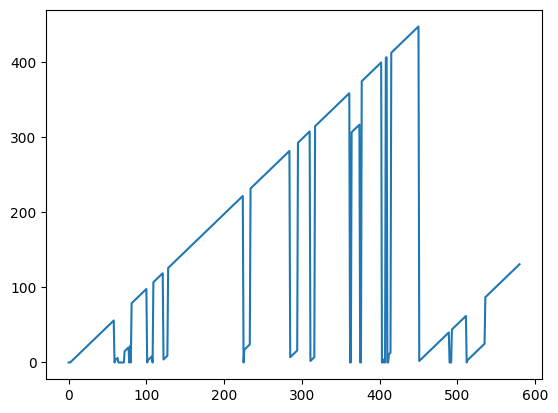

[ 57  76  78  99 120 223 283 309 360 373 401 408 449 488 510]


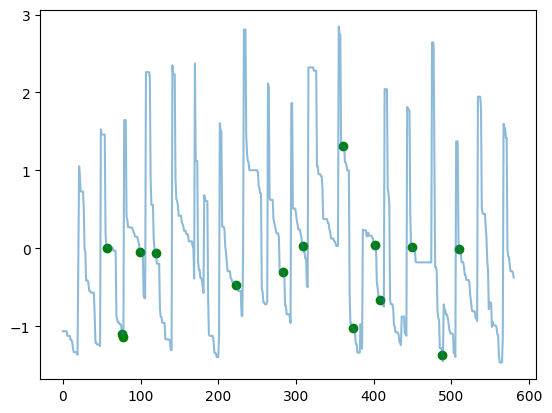

alpha100
beta0.01
kappa1
bank
F-Measure
0.11764705882352941
Covering
0.17728055077452667


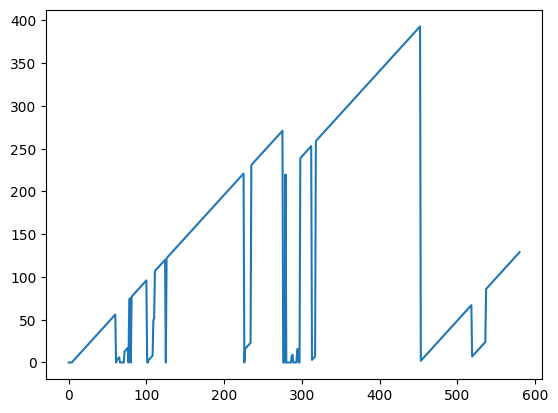

[ 58  74  77  98 122 223 273 277 293 310 450 516]


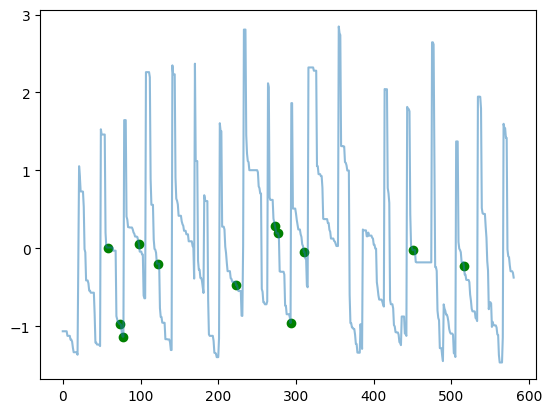

alpha100
beta0.01
kappa1
bank
F-Measure
0.14285714285714288
Covering
0.24096385542168672


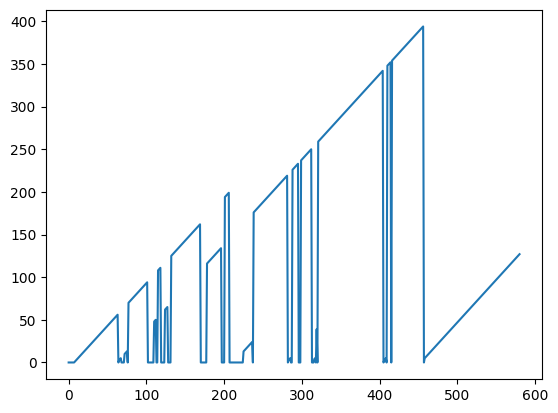

[ 59  71  97 108 114 123 165 192 202 232 277 291 308 315 400 410 452]


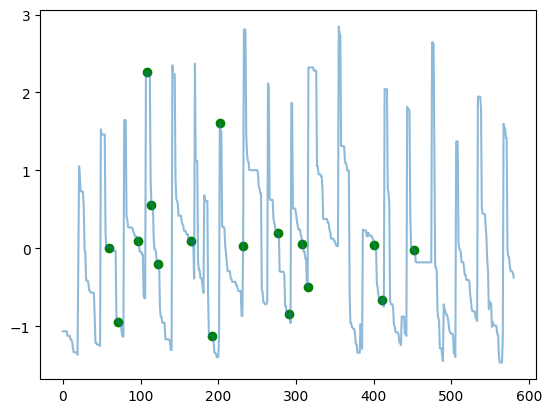

alpha100
beta0.01
kappa1
bank
F-Measure
0.10526315789473684
Covering
0.22203098106712565


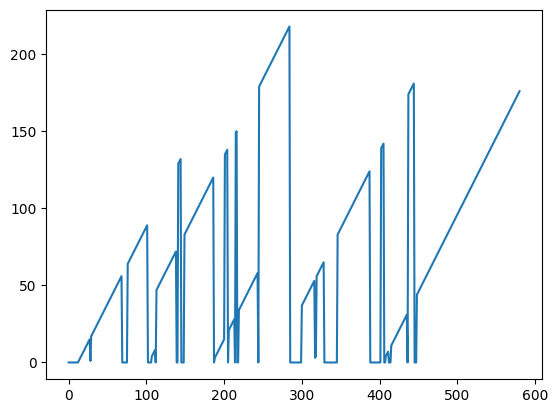

[ 21  62  95 132 138 180 198 207 210 237 278 310 322 381 399 429 438]


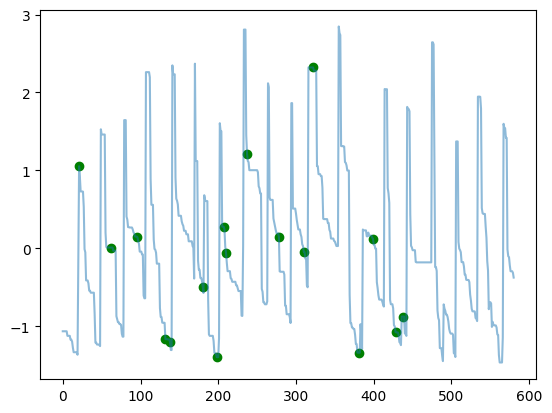

alpha100
beta0.01
kappa1
bank
F-Measure
0.10526315789473684
Covering
0.24612736660929432


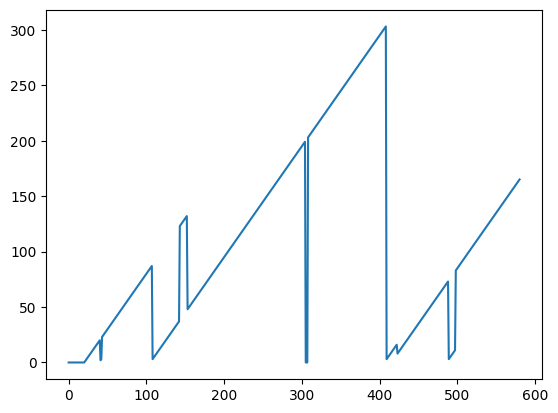

[ 30  97 142 294 398 478]


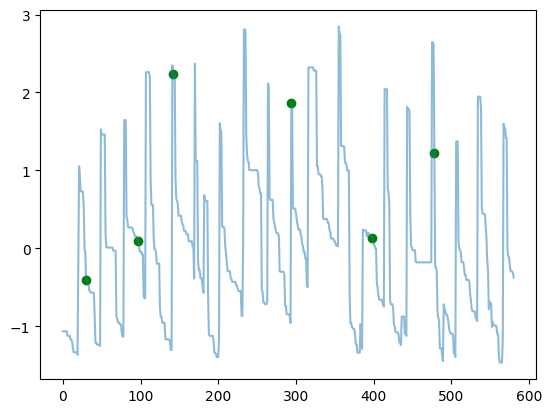

alpha100
beta0.01
kappa1
bank
F-Measure
0.25
Covering
0.26161790017211706


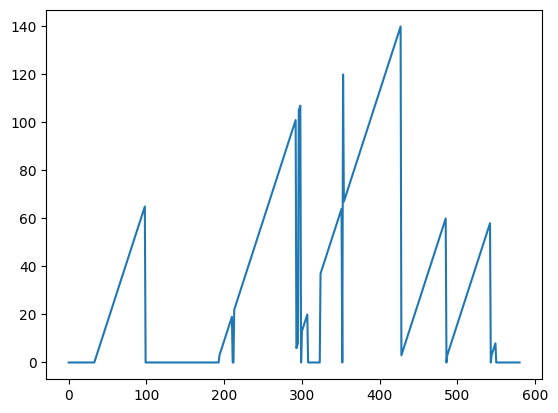

[ 81 193 275 281 290 334 336 410 468 525]


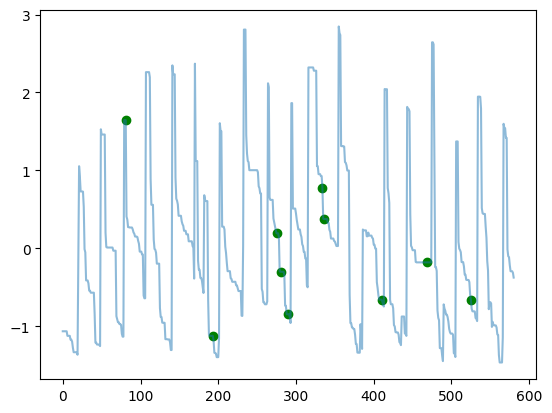

alpha100
beta0.01
kappa1
bank
F-Measure
0.16666666666666669
Covering
0.1927710843373494


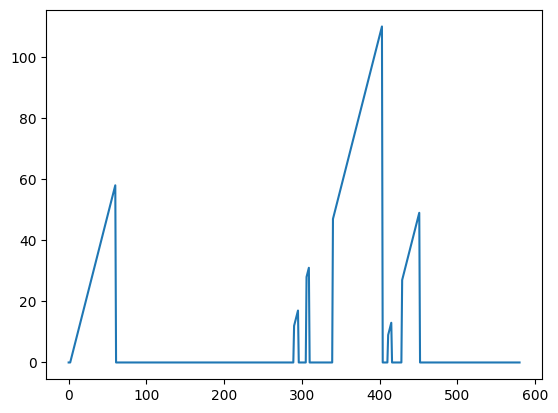

[ 59 294 308 402 414 450]


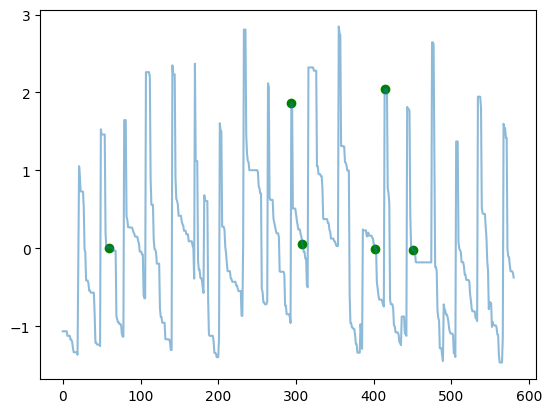

alpha100
beta0.01
kappa100
bank
F-Measure
0.25
Covering
0.40447504302925996


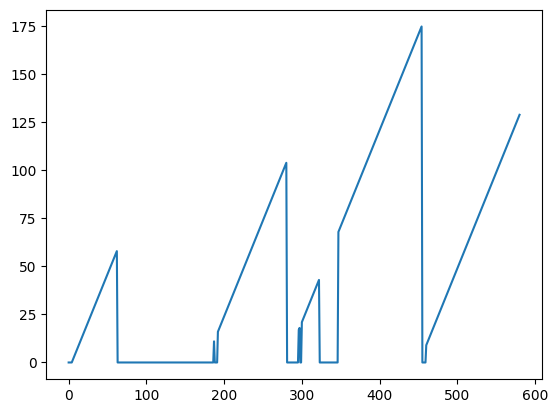

[ 60 278 295 320 452]


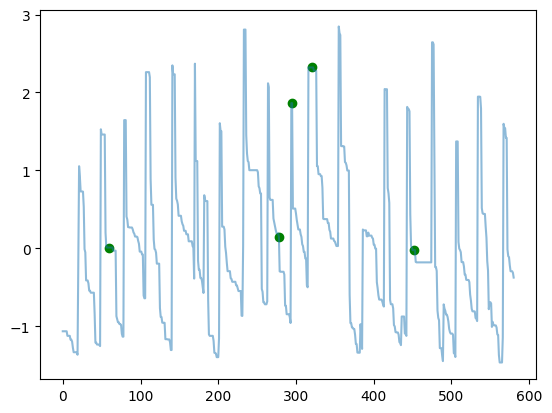

alpha100
beta0.01
kappa100
bank
F-Measure
0.2857142857142857
Covering
0.37521514629948366


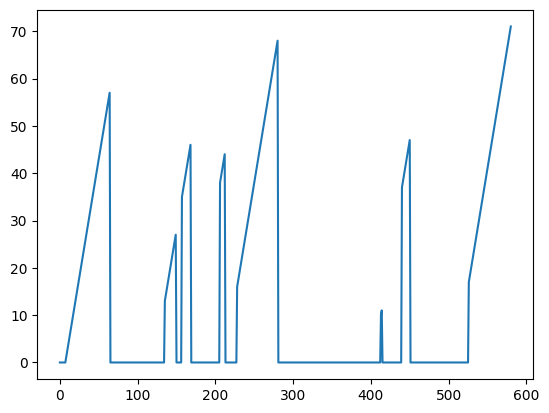

[ 60 145 164 208 276 446]


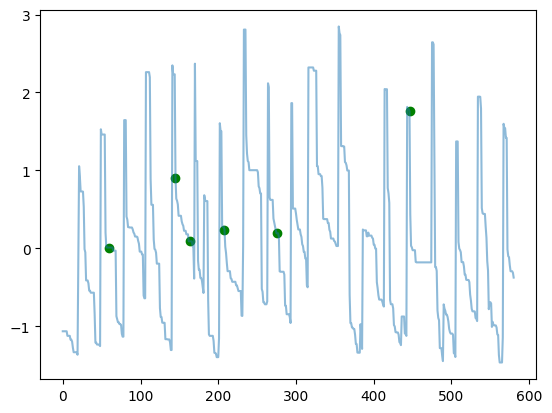

alpha100
beta0.01
kappa100
bank
F-Measure
0.25
Covering
0.29259896729776247


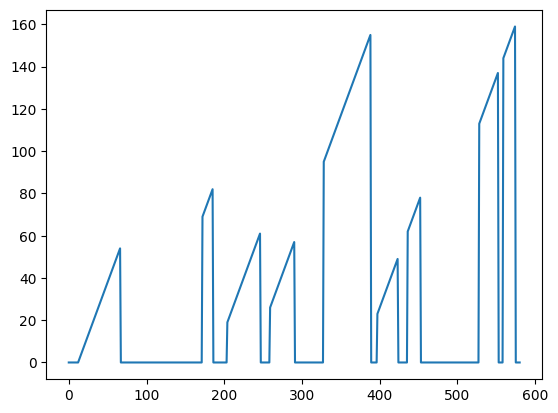

[ 60 179 240 284 382 417 446 546 568]


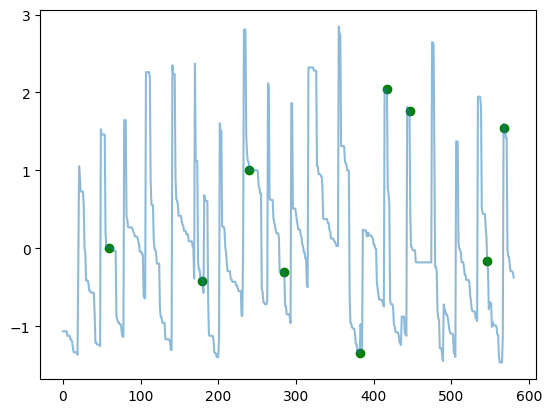

alpha100
beta0.01
kappa100
bank
F-Measure
0.18181818181818182
Covering
0.2048192771084337


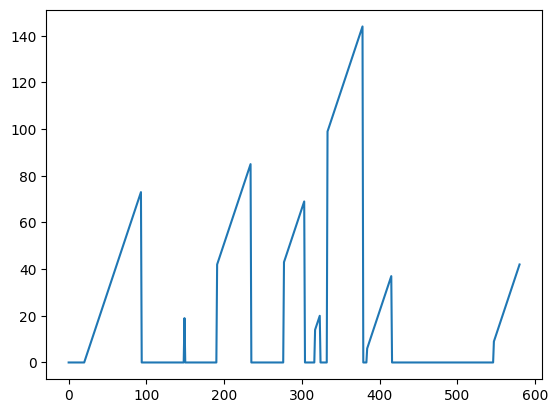

[ 83 139 224 293 313 368 405]


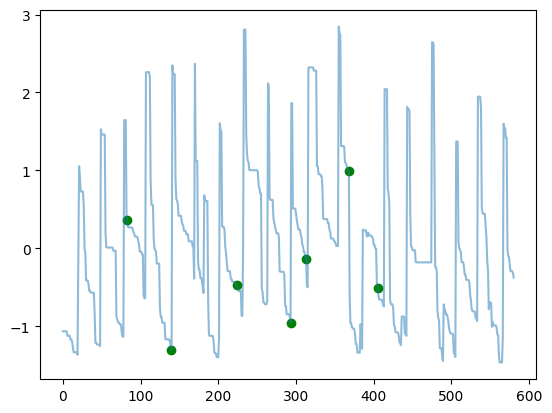

alpha100
beta0.01
kappa100
bank
F-Measure
0.2222222222222222
Covering
0.3029259896729776


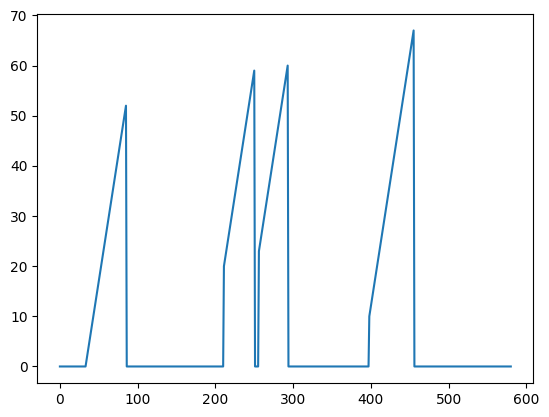

[ 68 233 276 438]


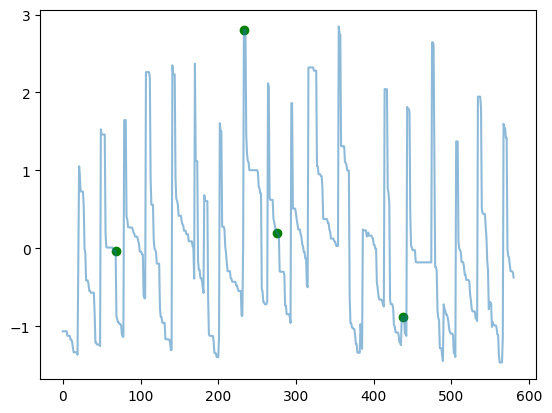

alpha100
beta0.01
kappa100
bank
F-Measure
0.33333333333333337
Covering
0.28399311531841653


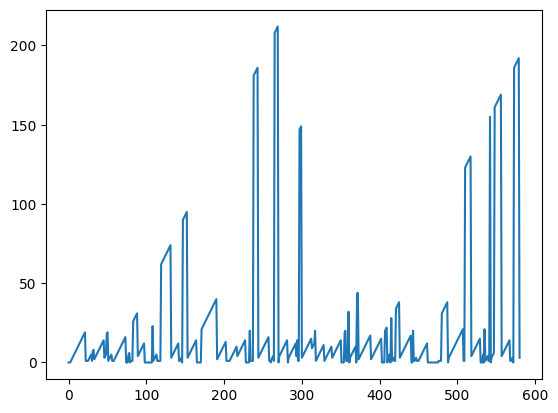

[ 20  49  72  87  96 107 130 151 163 189 201 226 232 242 256 268 280 293
 298 316 349 355 359 371 387 401 408 414 424 439 442 460 486 506 516 528
 534 541 555 566 578]


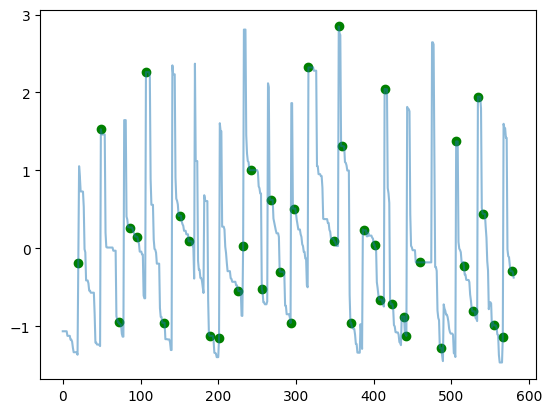

alpha100
beta1
kappa0.01
bank
F-Measure
0.046511627906976744
Covering
0.05679862306368331


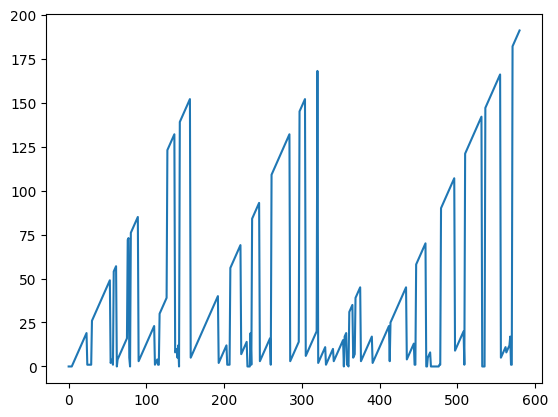

[ 21  51  59  75  87 108 134 139 154 190 219 227 232 243 257 282 302 318
 351 355 363 373 388 410 432 442 457 494 506 529 553 566]


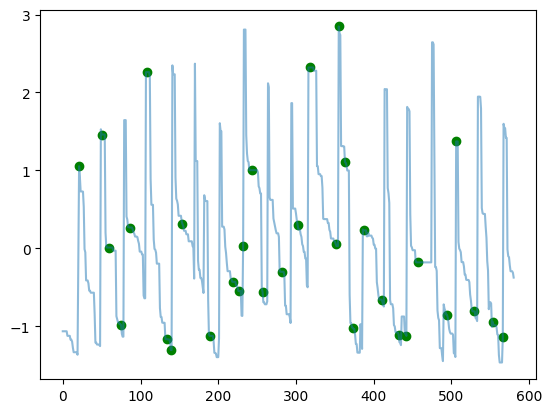

alpha100
beta1
kappa0.01
bank
F-Measure
0.05882352941176471
Covering
0.06368330464716007


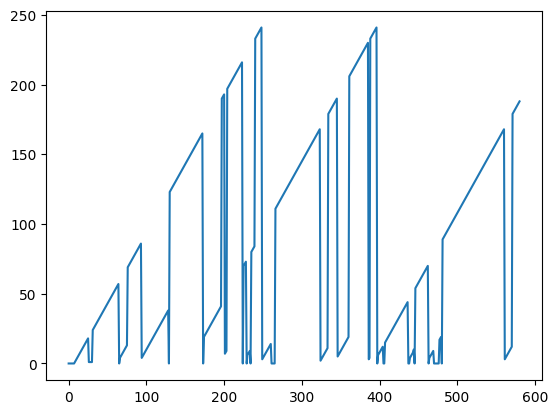

[ 21  60  89 124 168 196 219 224 244 256 319 341 381 392 400 432 458 475
 556]


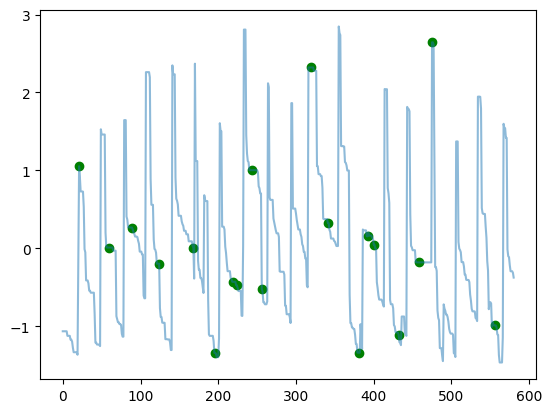

alpha100
beta1
kappa0.01
bank
F-Measure
0.09523809523809523
Covering
0.13941480206540446


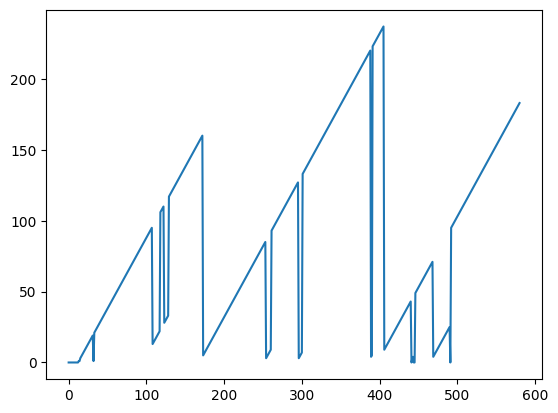

[ 25 101 116 166 247 289 382 399 434 462 484]


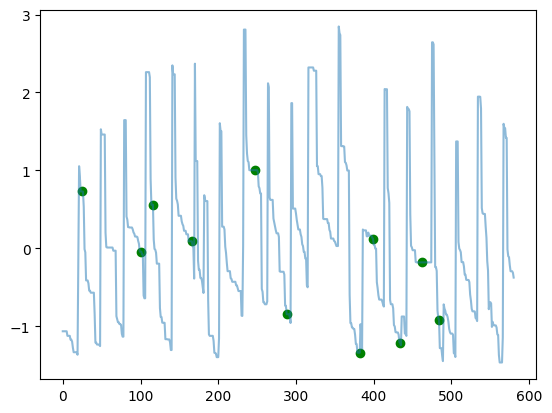

alpha100
beta1
kappa0.01
bank
F-Measure
0.15384615384615385
Covering
0.16695352839931152


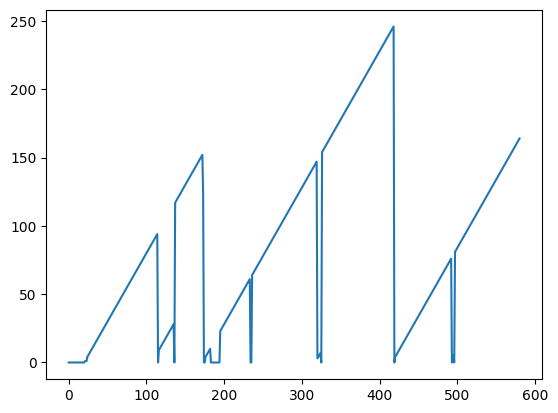

[104 125 162 163 223 309 408 482]


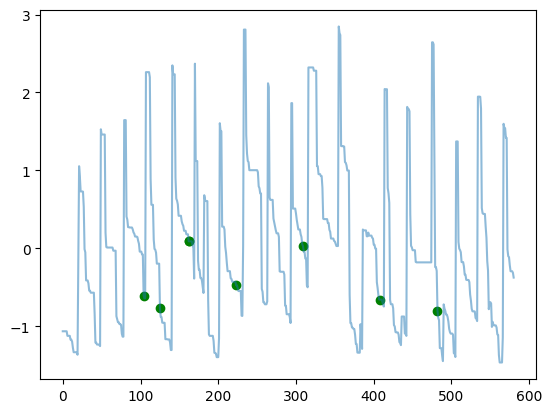

alpha100
beta1
kappa0.01
bank
F-Measure
0.19999999999999998
Covering
0.17900172117039587


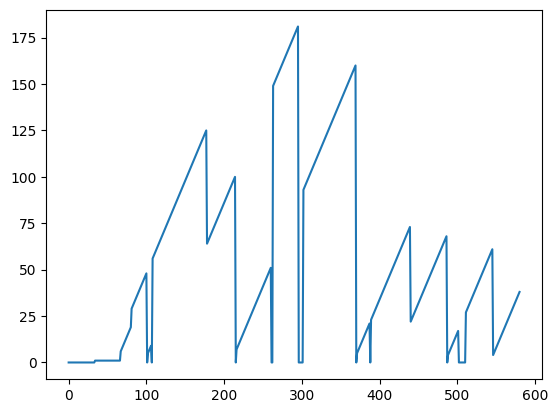

[ 83 160 197 243 278 352 370 422 469 484 528]


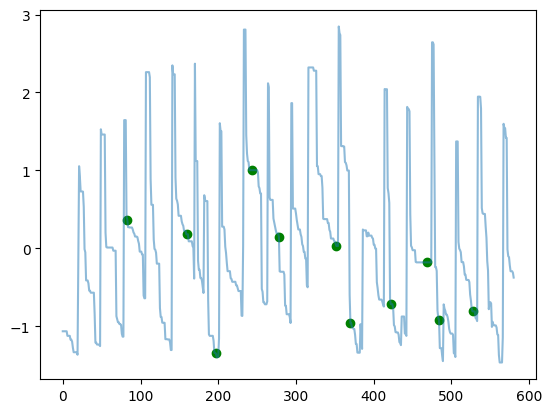

alpha100
beta1
kappa0.01
bank
F-Measure
0.15384615384615385
Covering
0.14285714285714285


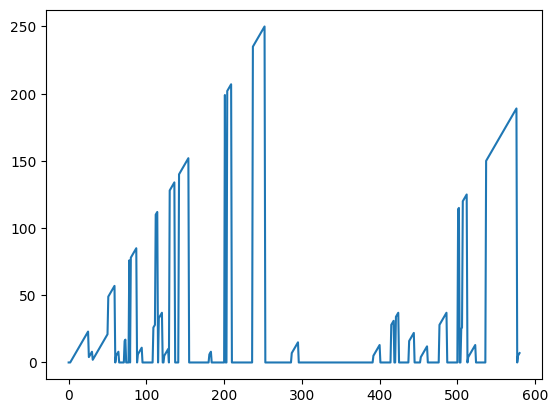

[ 24  58  72  77  86 113 119 135 153 200 208 251 294 399 417 423 443 460
 485 501 511 522 575]


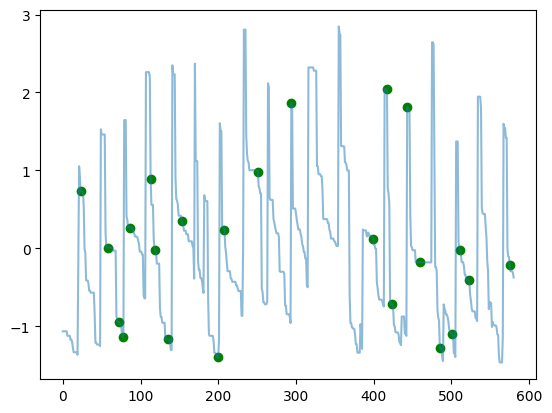

alpha100
beta1
kappa1
bank
F-Measure
0.07999999999999999
Covering
0.18072289156626506


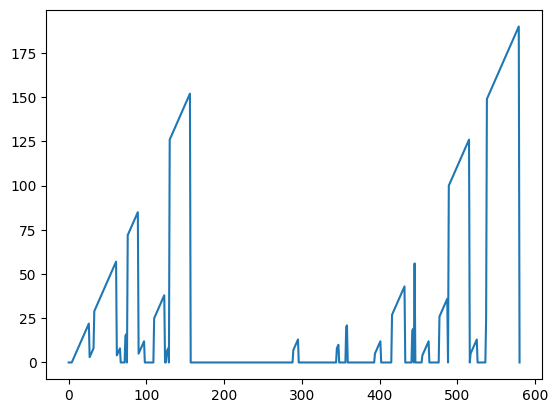

[ 24  59  72  87  95 121 154 293 356 399 430 441 443 461 485 513 523 577]


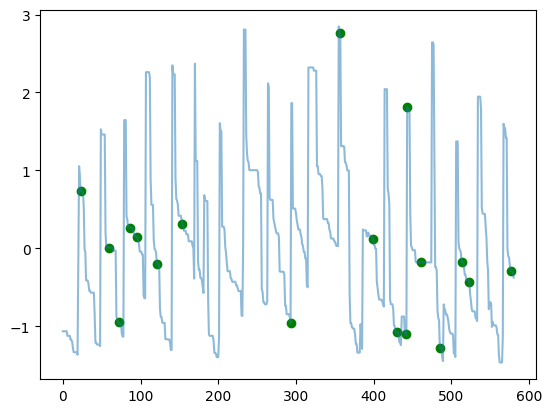

alpha100
beta1
kappa1
bank
F-Measure
0.1
Covering
0.23924268502581753


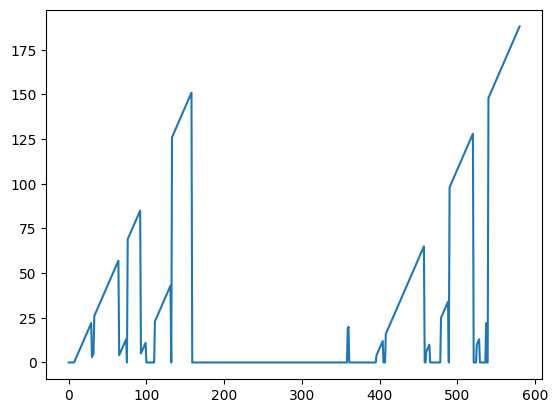

[ 25  60  70  88 127 154 356 400 453 484 516 524 533]


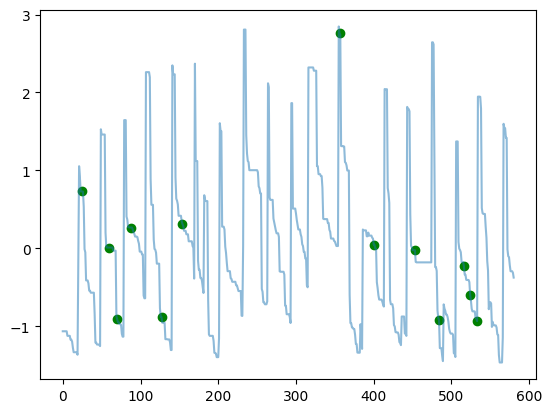

alpha100
beta1
kappa1
bank
F-Measure
0.13333333333333333
Covering
0.3476764199655766


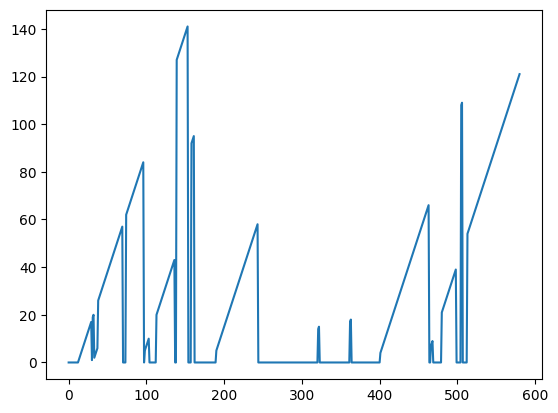

[ 23  26  63  90 130 147 155 237 316 357 457 492 500]


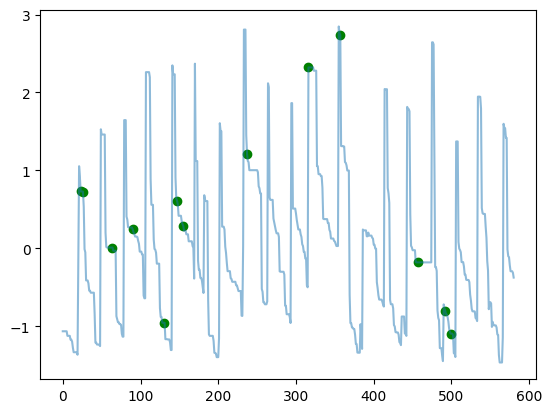

alpha100
beta1
kappa1
bank
F-Measure
0.13333333333333333
Covering
0.1721170395869191


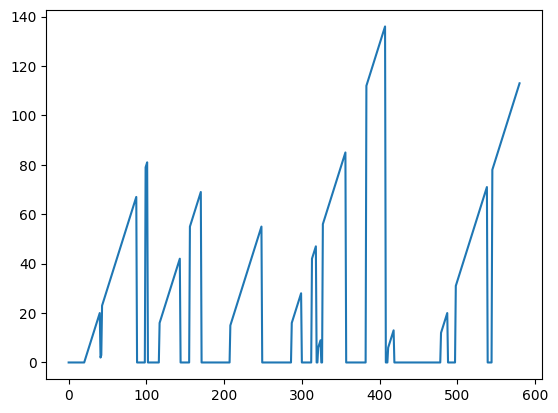

[ 30  77  91 133 160 238 289 308 346 397 408 477 528]


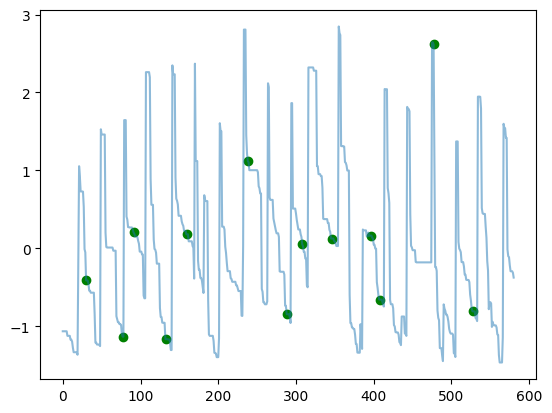

alpha100
beta1
kappa1
bank
F-Measure
0.13333333333333333
Covering
0.1342512908777969


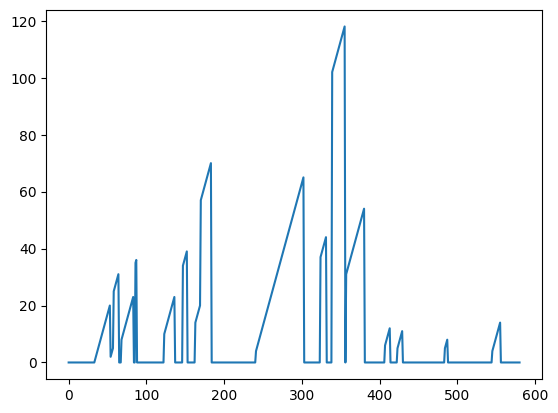

[ 36  47  66  70 119 135 166 285 314 338 363 396 538]


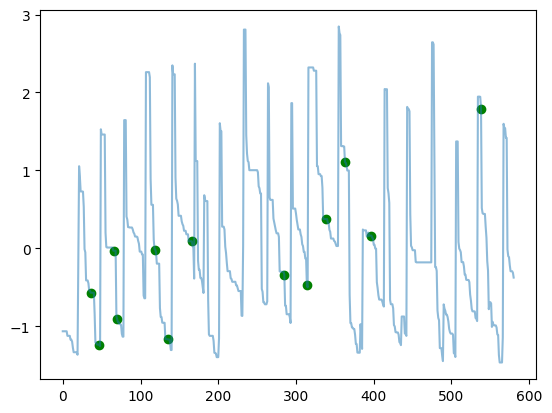

alpha100
beta1
kappa1
bank
F-Measure
0.13333333333333333
Covering
0.24440619621342513


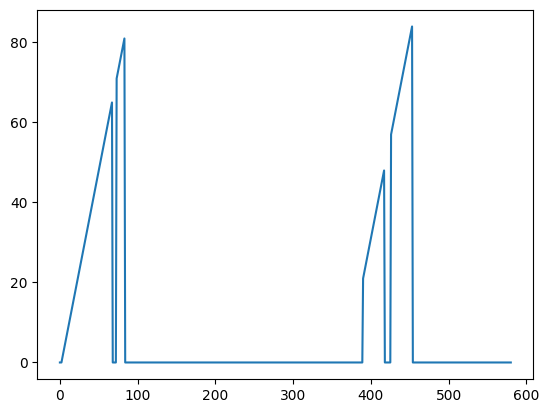

[ 66  82 416 452]


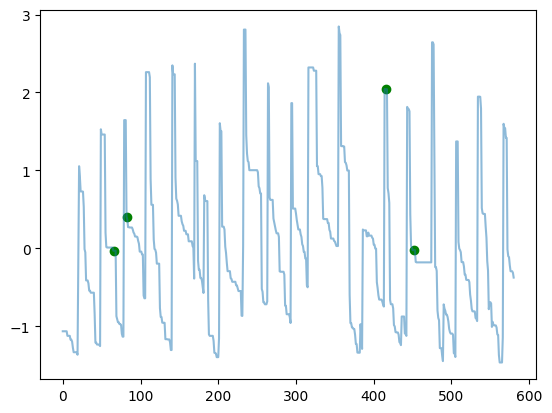

alpha100
beta1
kappa100
bank
F-Measure
0.33333333333333337
Covering
0.5748709122203098


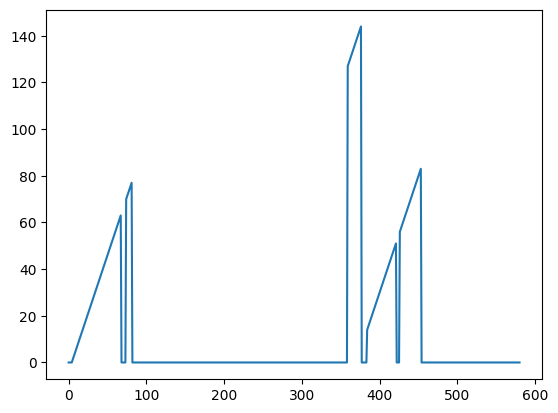

[ 65  79 374 419 451]


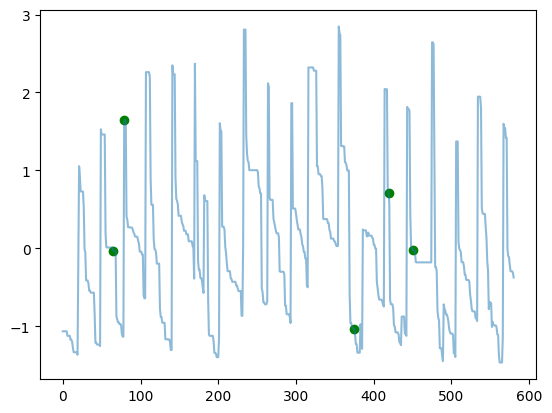

alpha100
beta1
kappa100
bank
F-Measure
0.2857142857142857
Covering
0.5077452667814114


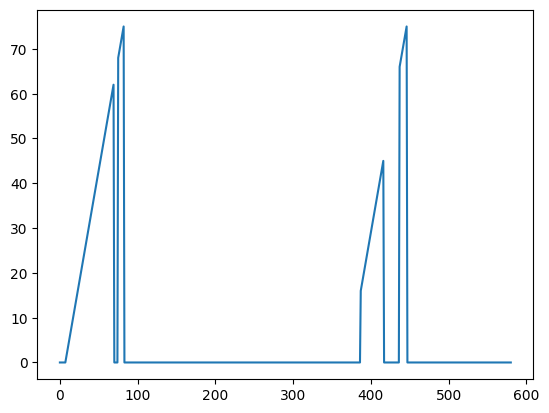

[ 65  78 412 442]


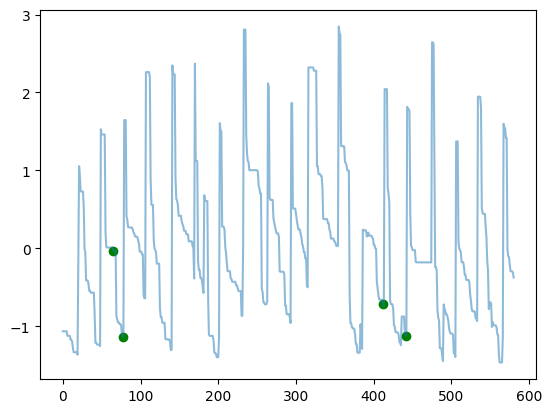

alpha100
beta1
kappa100
bank
F-Measure
0.33333333333333337
Covering
0.5748709122203098


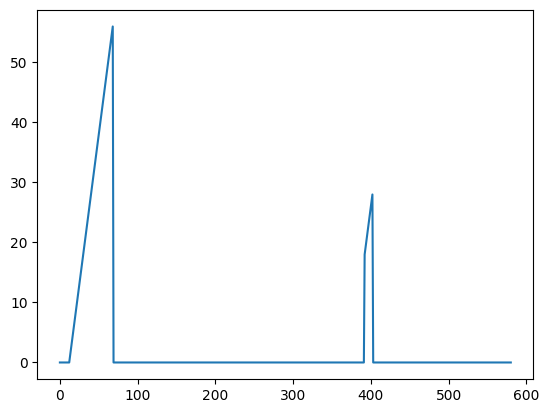

[ 62 396]


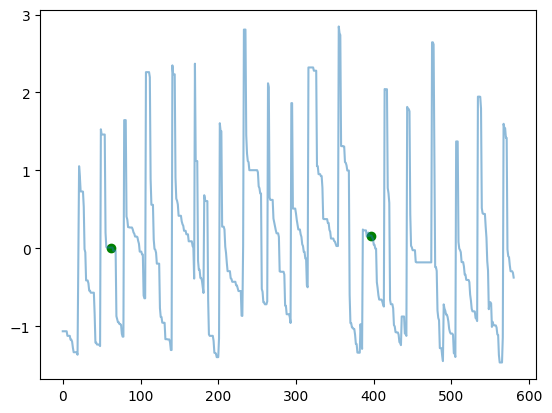

alpha100
beta1
kappa100
bank
F-Measure
0.5
Covering
0.5748709122203098


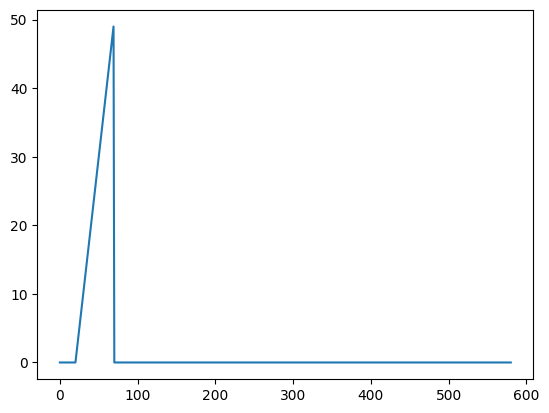

[59]


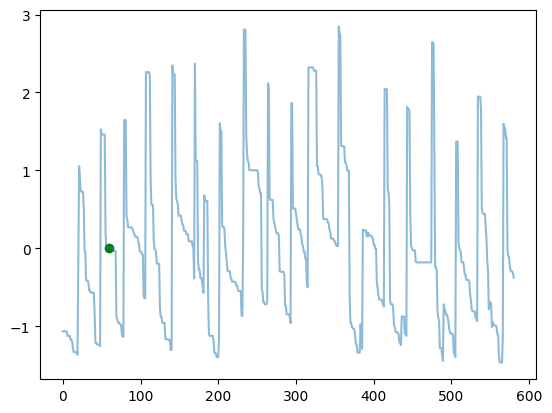

alpha100
beta1
kappa100
bank
F-Measure
0.6666666666666666
Covering
0.8984509466437178


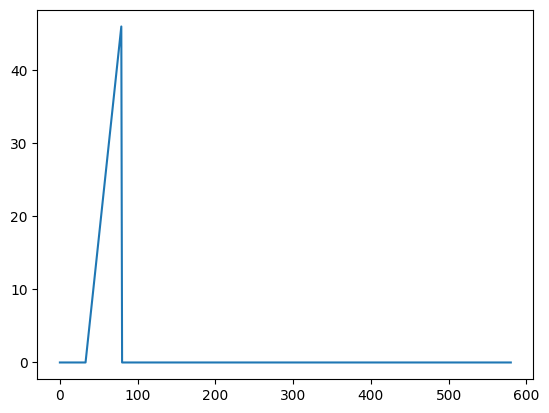

[62]


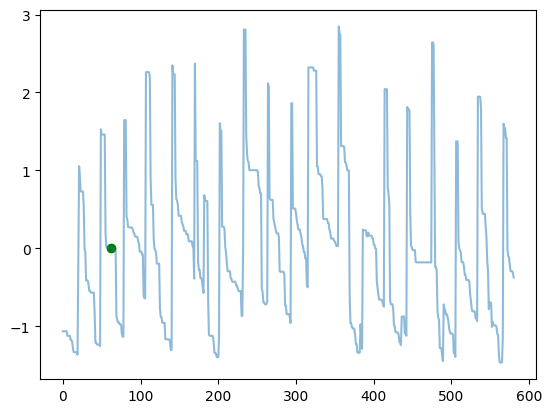

alpha100
beta1
kappa100
bank
F-Measure
0.6666666666666666
Covering
0.89328743545611


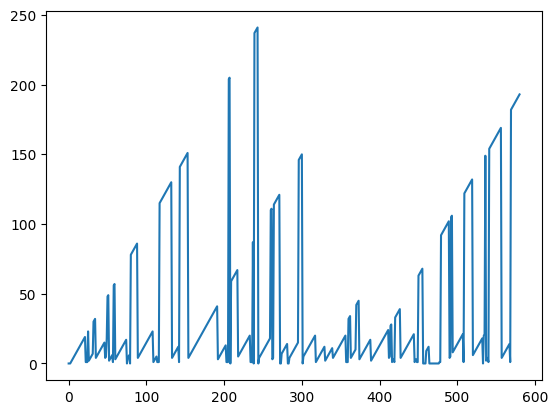

[ 20  24  33  50  58  73  87 107 131 152 190 201 206 216 232 236 242 260
 270 280 299 316 355 361 372 387 410 414 425 443 454 462 488 492 506 518
 531 535 555 566]


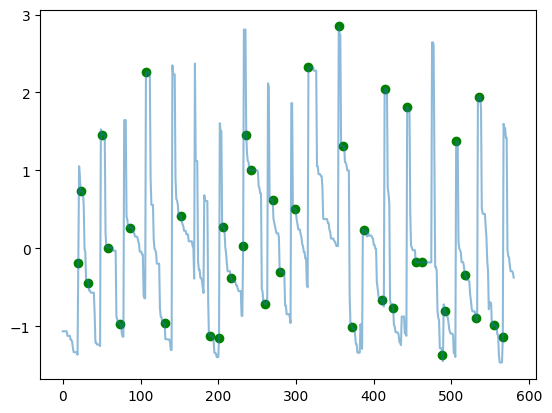

alpha100
beta100
kappa0.01
bank
F-Measure
0.047619047619047616
Covering
0.06712564543889846


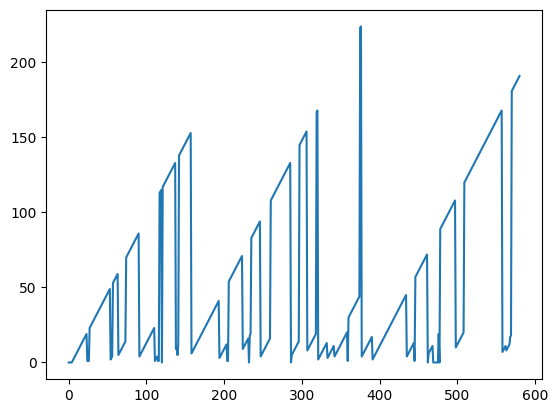

[ 21  51  61  88 108 117 135 155 191 221 229 244 283 304 318 356 374 388
 432 442 459 474 495 555]


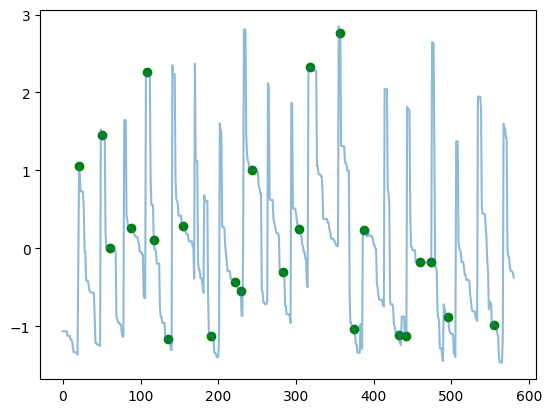

alpha100
beta100
kappa0.01
bank
F-Measure
0.07692307692307693
Covering
0.10327022375215147


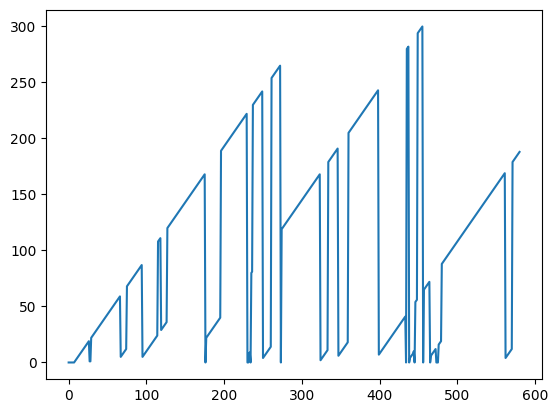

[ 22  62  90 114 171 225 245 268 319 342 394 429 433 451 460 468 557]


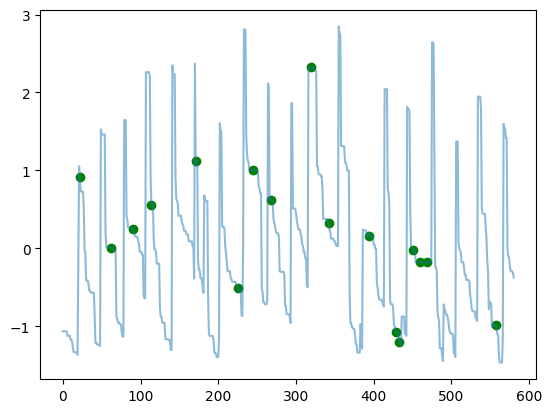

alpha100
beta100
kappa0.01
bank
F-Measure
0.10526315789473684
Covering
0.153184165232358


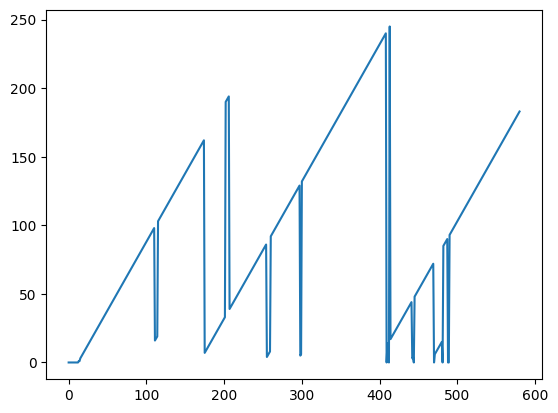

[104 168 200 248 291 402 405 407 435 463 474 481]


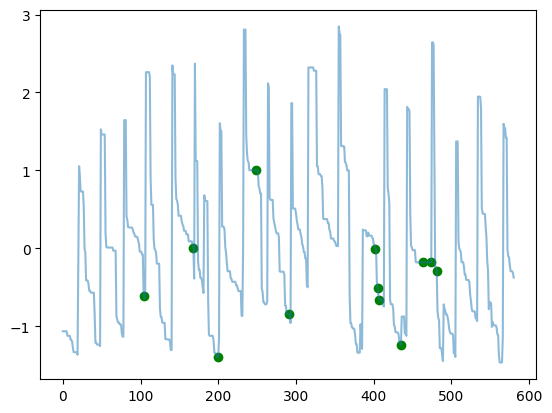

alpha100
beta100
kappa0.01
bank
F-Measure
0.14285714285714288
Covering
0.19104991394148021


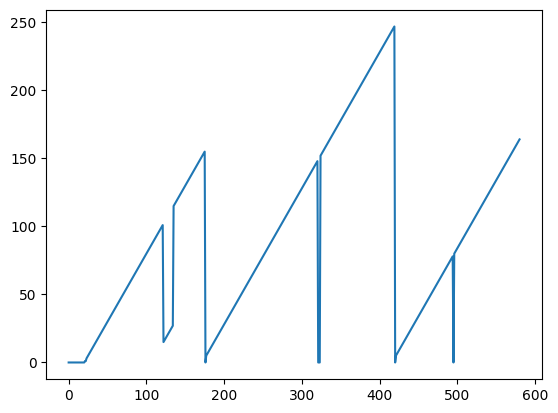

[111 165 310 409 484]


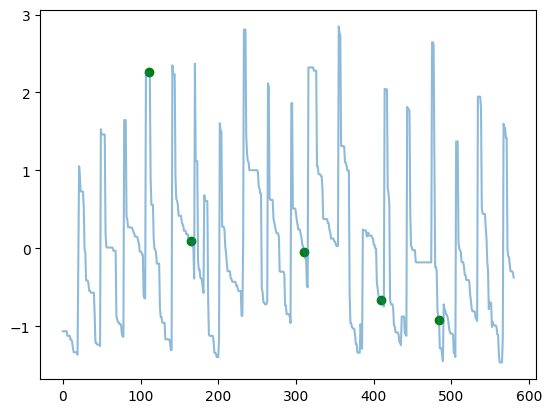

alpha100
beta100
kappa0.01
bank
F-Measure
0.2857142857142857
Covering
0.2495697074010327


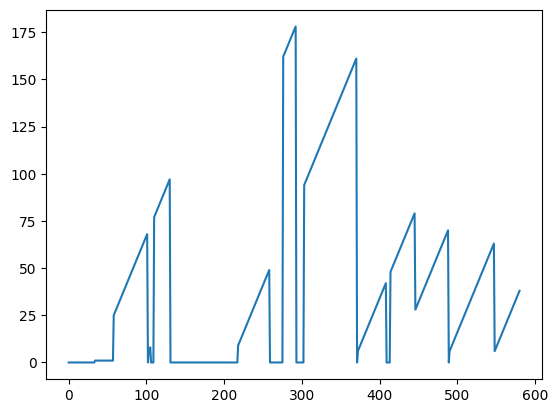

[ 84 113 241 275 353 391 428 471 530]


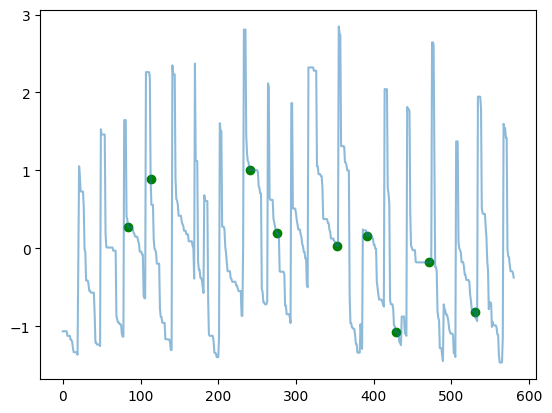

alpha100
beta100
kappa0.01
bank
F-Measure
0.18181818181818182
Covering
0.2203098106712565


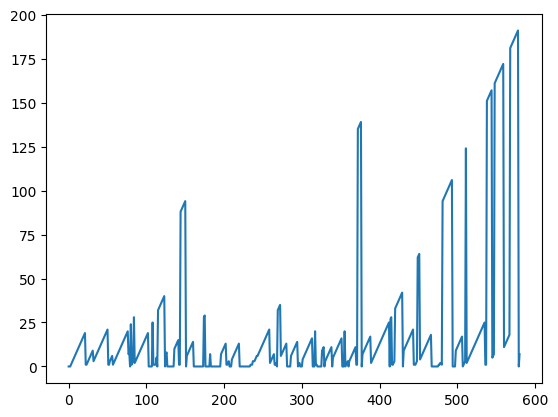

[ 20  49  75  79  83 101 107 122 140 149 159 174 201 218 257 271 279 293
 312 316 350 354 375 387 411 414 428 442 450 465 492 505 510 534 543 558
 577]


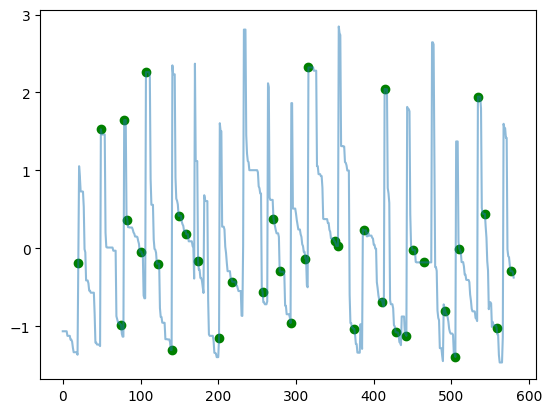

alpha100
beta100
kappa1
bank
F-Measure
0.05128205128205127
Covering
0.06712564543889846


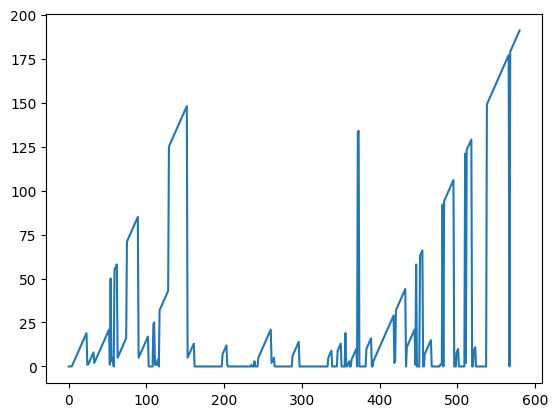

[ 21  50  52  60  87 100 108 150 159 258 294 348 354 371 387 416 431 443
 445 453 464 479 493 508 516 564]


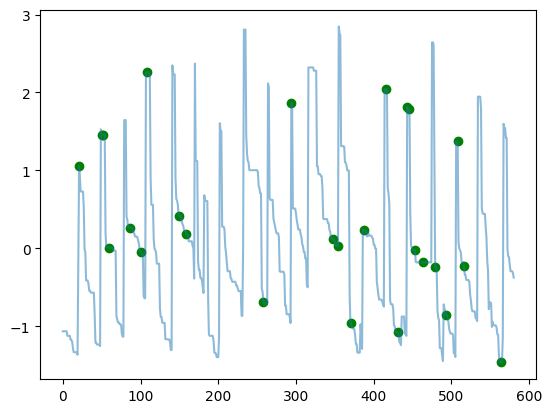

alpha100
beta100
kappa1
bank
F-Measure
0.07142857142857142
Covering
0.1703958691910499


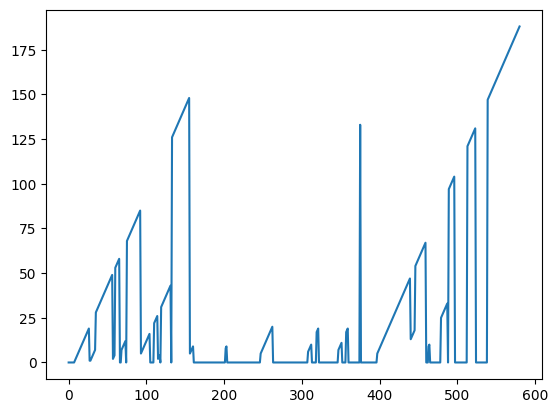

[ 22  52  61  69  88 100 110 127 151 258 317 355 371 435 455 483 492 519]


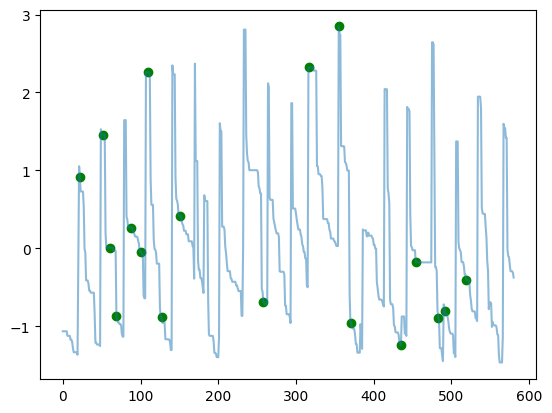

alpha100
beta100
kappa1
bank
F-Measure
0.1
Covering
0.18416523235800344


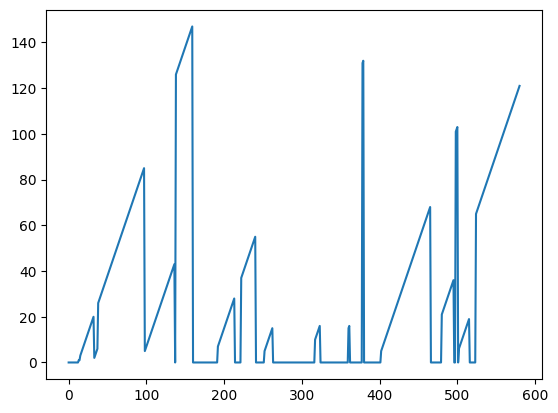

[ 26  91 130 153 207 234 256 317 355 373 459 489 494 509]


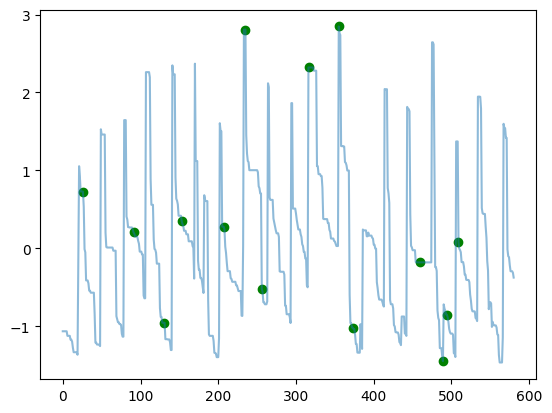

alpha100
beta100
kappa1
bank
F-Measure
0.125
Covering
0.14802065404475043


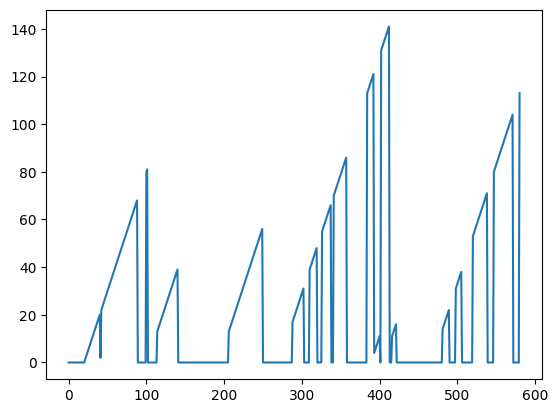

[ 30  78  91 130 239 292 309 327 347 382 402 411 479 495 528 561]


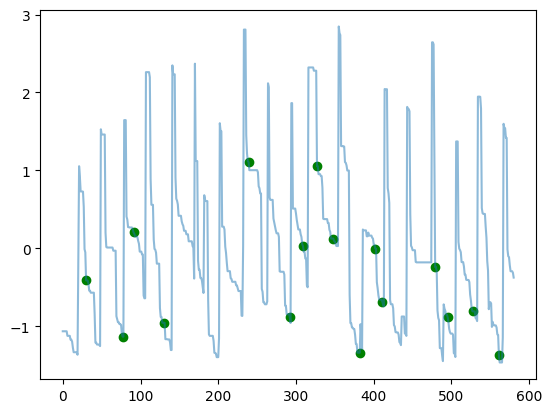

alpha100
beta100
kappa1
bank
F-Measure
0.1111111111111111
Covering
0.18760757314974183


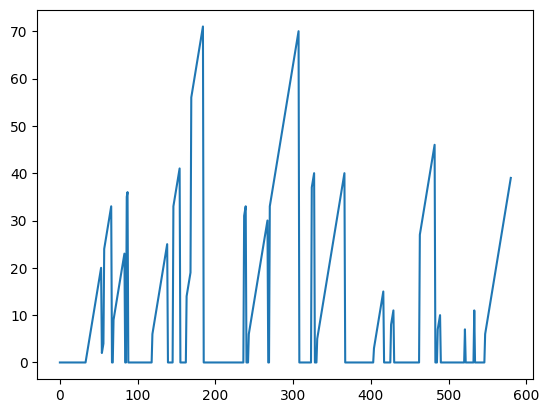

[ 36  49  66  70 121 137 167 222 250 290 310 349 399 465]


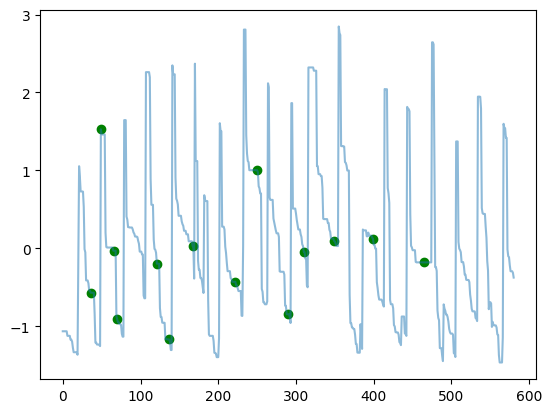

alpha100
beta100
kappa1
bank
F-Measure
0.125
Covering
0.19965576592082615


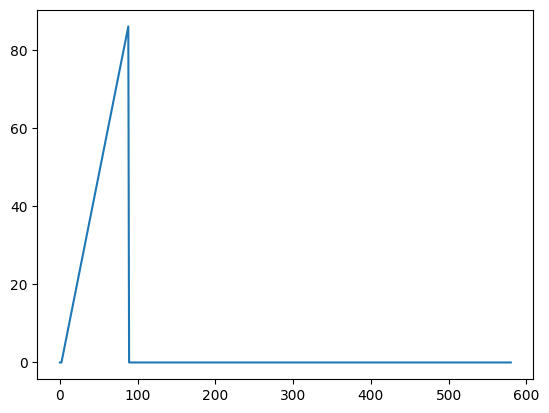

[87]


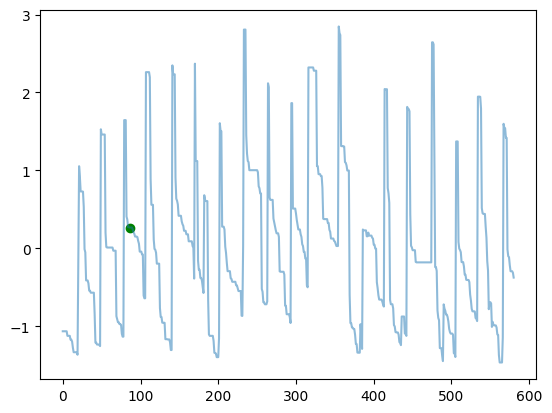

alpha100
beta100
kappa100
bank
F-Measure
0.6666666666666666
Covering
0.8502581755593803


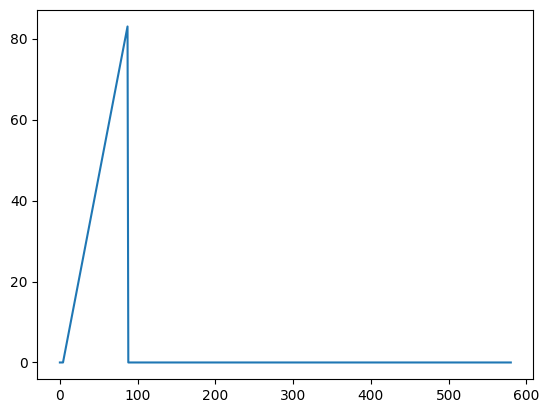

[85]


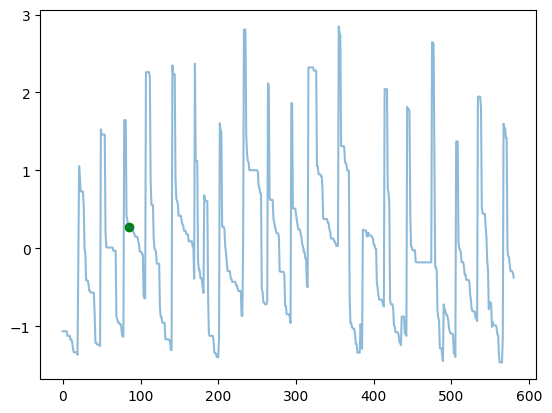

alpha100
beta100
kappa100
bank
F-Measure
0.6666666666666666
Covering
0.8537005163511188


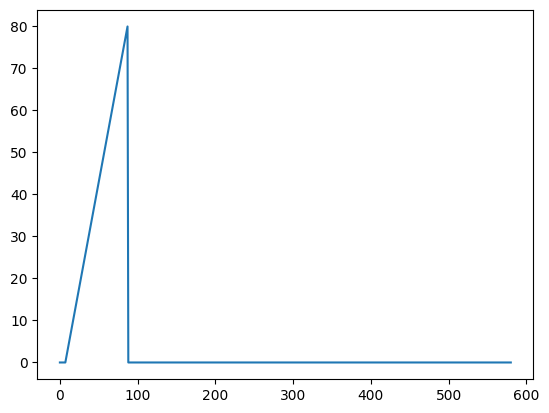

[83]


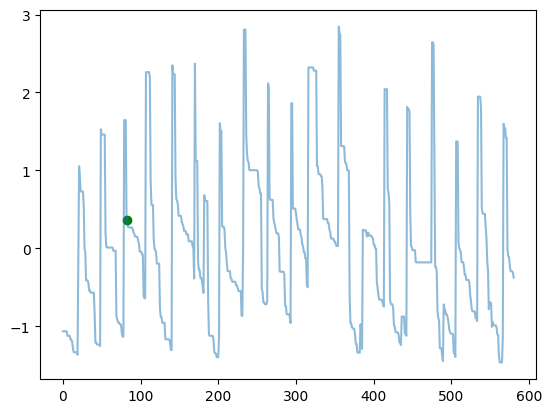

alpha100
beta100
kappa100
bank
F-Measure
0.6666666666666666
Covering
0.8571428571428571


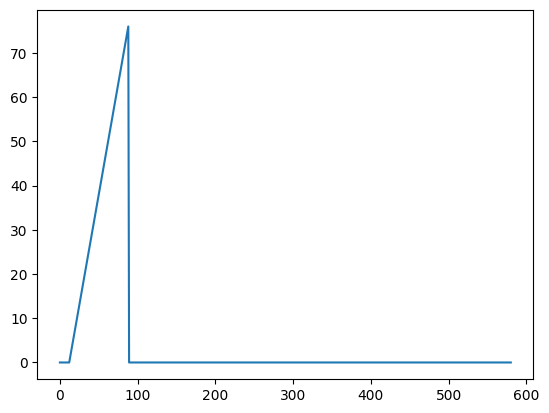

[82]


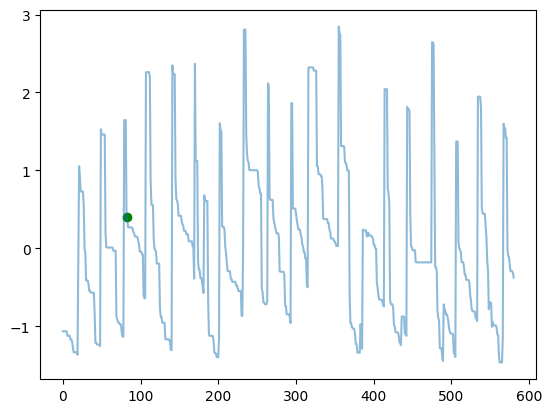

alpha100
beta100
kappa100
bank
F-Measure
0.6666666666666666
Covering
0.8588640275387263


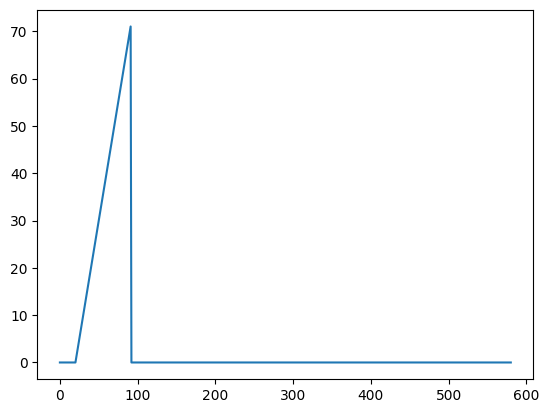

[81]


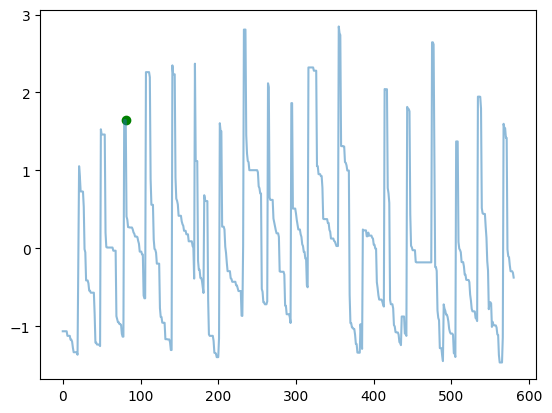

alpha100
beta100
kappa100
bank
F-Measure
0.6666666666666666
Covering
0.8605851979345955


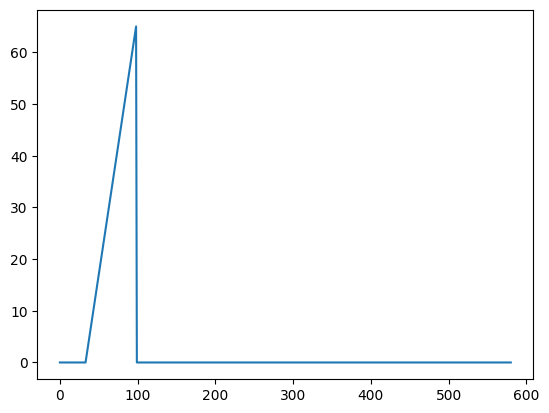

[81]


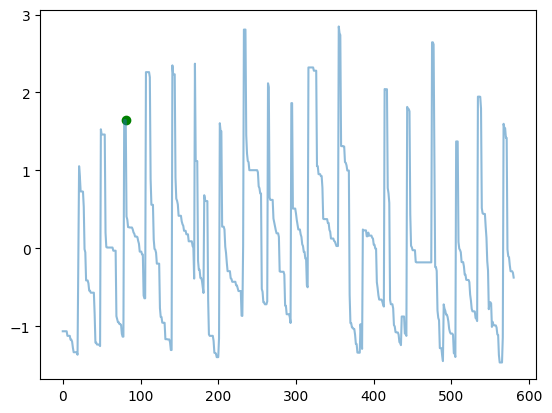

alpha100
beta100
kappa100
bank
F-Measure
0.6666666666666666
Covering
0.8605851979345955
0.9122203098106713

0.6666666666666666


In [10]:
counter = 0
fMeasures = np.zeros(len(DATASETS))
coverings = np.zeros(len(DATASETS))


alpha = [0.01,1,100]
beta = [0.01,1,100]
kappa = [0.01,1,100]
hazard = [50,100,200]
segmentLength = [3,5,8,13,21,34]

for a in alpha:
    for b in beta:
        for k in kappa:
            for l in segmentLength:
                for n,datasetName in enumerate(DATASETS):
                    studentTQueue = []

                    bc = BayesianOnlineChangePointDetection_Segment(ConstantHazard(300), StudentT(mu=0, kappa=k, alpha=a, beta=b))
                    
                    
                    testSignal=stdTestingData[0]
                    historicalData = []
                    rt_mle = np.empty(testSignal.shape)
                    L = l

                    cuttoff = math.floor(len(testSignal)/50)
                    allData = []

                    # Online estimation and get the maximum likelihood r_t at each time point
                    for i, d in enumerate(testSignal):
                        #print(d)
                        #print(testSignal[0:20])
                        allData.append(d)
                        if i >= L:
                            for j in range(len(historicalData)):
                                historicalData[j].append(testSignal[i-L])
                            historicalData.insert(0,[testSignal[i-L]])
                            localData = np.asarray(allData[-L:])
                            
                            bc.update(localData,studentTQueue,historicalData)
                            rt_mle[i] = bc.rt
                        else: 
                            rt_mle[i] = 0

                    plt.plot(rt_mle)
                    plt.show()
                    # Plot data with estimated change points
                    plt.plot(testSignal, alpha=0.5, label="observation")
                    
                    index_changes = np.where(np.diff(rt_mle)<-cuttoff)[0]-int(L/2)
                    if(f_measure(annotations[datasetName], index_changes) == 1.0):
                        print(l)
                        print('********************************')
                        continue
                    print(index_changes)
                    plt.scatter(index_changes, testSignal[index_changes], c='green', label="change point")
                    plt.show()
                    
                    print('alpha' + str(a))
                    print('beta' + str(b))
                    print('kappa' + str(k))
                    
                    print(datasetName)
                    
                    print("F-Measure")
                    print(f_measure(annotations[datasetName], index_changes))
                    
                    fMeasure = f_measure(annotations[datasetName], index_changes)
                    if fMeasure > fMeasures[n]:
                        fMeasures[n] = fMeasure
                   
                    print("Covering")
                    covering = Covering(annotations[datasetName], index_changes,len(testSignal))
                    print(covering)
                    if covering > coverings[n]:
                        coverings[n] = covering
                        
for c in coverings:
    print(c)
print()
for c in fMeasures:
    print(c)                      

